In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.3 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [29]:
adata = sc.read('2301_annot_patient_integrated_ambient_removed.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 226459 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'leiden_coarse', 'leiden_fine', 'leiden_subset', 'celltype_fine', 'celltype_approx', 'ambient', 'trt_category'
    var: 'used_for_scvi'
    uns: '_scvi', 'ambient_colors', 'cell_type_colors', 'celltype_approx_colors', 'celltype_coarse_colors', 'celltype_fine_colors', 'dendrogram_leiden_fine', 'hvg', 'infected_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_fine_colors', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'trt_categories', 'trt_category_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [4]:
pd.crosstab(adata.obs.treatment, adata.obs.patient)

patient               Patient 1  Patient 2  Patient 3  Patient 4
treatment                                                       
BB94                          0          0          0       2625
DMSO                          0          0          0       1541
Gilteritinib                  0          0          0       2590
IFNL                          0          0       3957       3462
IFNa                       3627       5706       3458       3360
IFNa + TNFa                3712          0       5500       2914
IFNg                       3471       4131       4874       3404
IFNg + TGFb2                  0          0       3755       3160
Sorafenib                  3413          0       3943       4417
TGFb2                      3691       3703       4514       3504
TGFb2 + Tirapazamine          0          0       3168       3649
TNFa                       3245       3828       4552       2600
TNFa + IFNg                3354          0       3110       2771
TNFa + TGFb2               2652          0       3546       3101
TNFa + Tirapazamine        4164          0       3693       2460
Tirapazamine               3101       2327       4243       3605
mock                       6752       4888       8687       5732
nan                           0          0      29765      15034

## Calculate categories

Take conditions appearing in all patients:

In [11]:
df = pd.crosstab(adata.obs.treatment, adata.obs.patient)
shared_conds = list(df.index[df.all(axis=1).values])

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


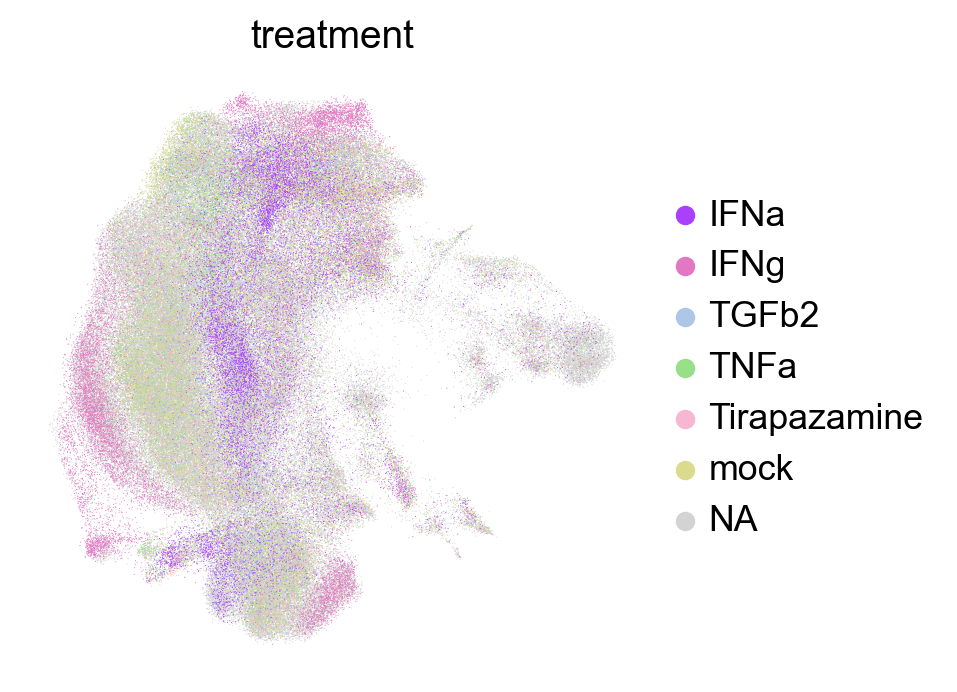

In [38]:
sc.pl.umap(adata, color='treatment', groups=shared_conds)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


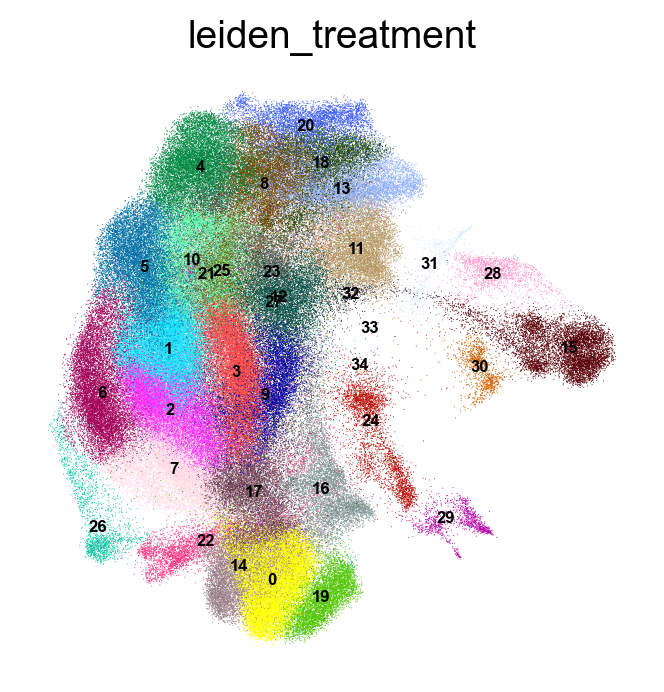

In [142]:
%%time
sc.tl.leiden(adata, resolution=2.5, key_added='leiden_treatment')
sc.pl.umap(adata, color='leiden_treatment', legend_loc='on data', legend_fontsize=6)

Label each leiden cluster with a treatment category.

In [205]:
# get percent nans per cluster and filter out
df = pd.concat([
    pd.DataFrame(adata.obs.leiden_treatment.value_counts()),
    pd.DataFrame(adata[adata.obs.treatment == 'nan'].obs.leiden_treatment.value_counts())
], axis=1).fillna(0)
df.columns = ['total', 'nans']
df['percent_nan'] = df.values[:, 1]/df.values[:, 0]
assign_clusters = df[(df.total > 100) & (df.percent_nan < .30)].index

<AxesSubplot: xlabel='treatment', ylabel='leiden_treatment'>

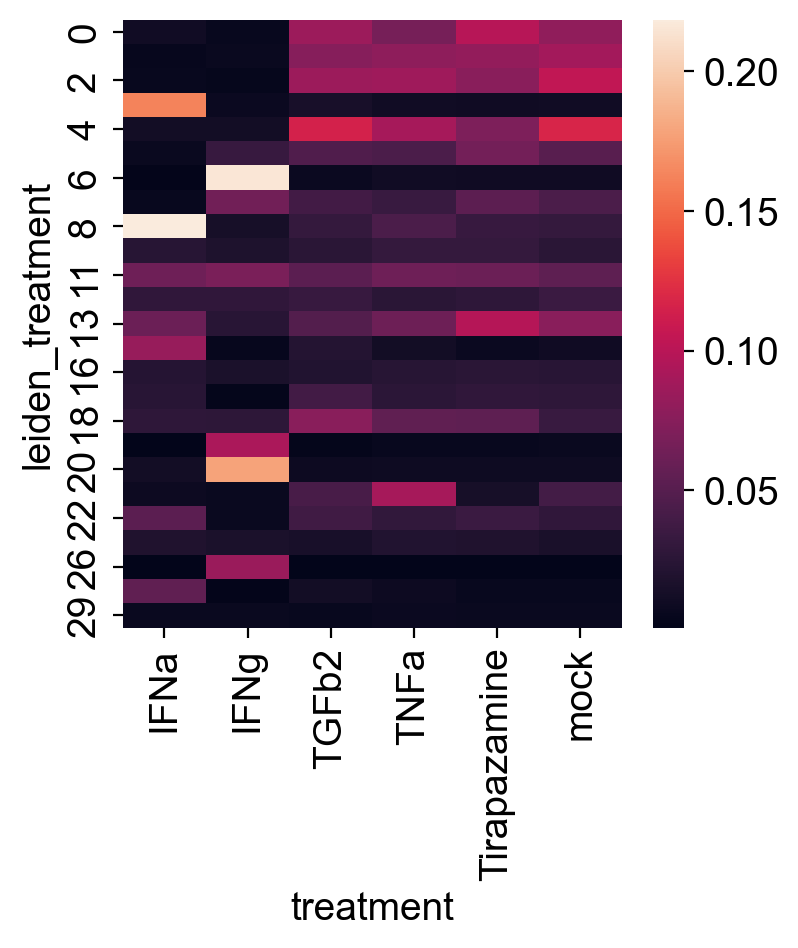

In [206]:
obs_df = pd.crosstab(adata.obs.leiden_treatment, adata.obs.treatment)
obs_df /= obs_df.sum(axis=0)
sns.heatmap(obs_df.T[assign_clusters].T[shared_conds])

There are some clusters that clearly belong to a condition and otherwise it's unclear. Only assign a cluster a category if it's significantly enriched with a condition.

In [240]:
signif_thresh = 2
assign_dict = {}
for c in adata.obs.leiden_treatment.cat.categories:
    if c not in assign_clusters:  # ones with too many nans
        pass
#         assign_dict[c] = 'no_category'
    else:
        n_large = obs_df[shared_conds].T[c].nlargest(2)
        if n_large[0] > n_large[1]*signif_thresh:
            assign_dict[c] = n_large.index[0]
        else:
            assign_dict[c] = 'mock'
            
adata.obs['trt_category'] = adata.obs.leiden_treatment.map(assign_dict)

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


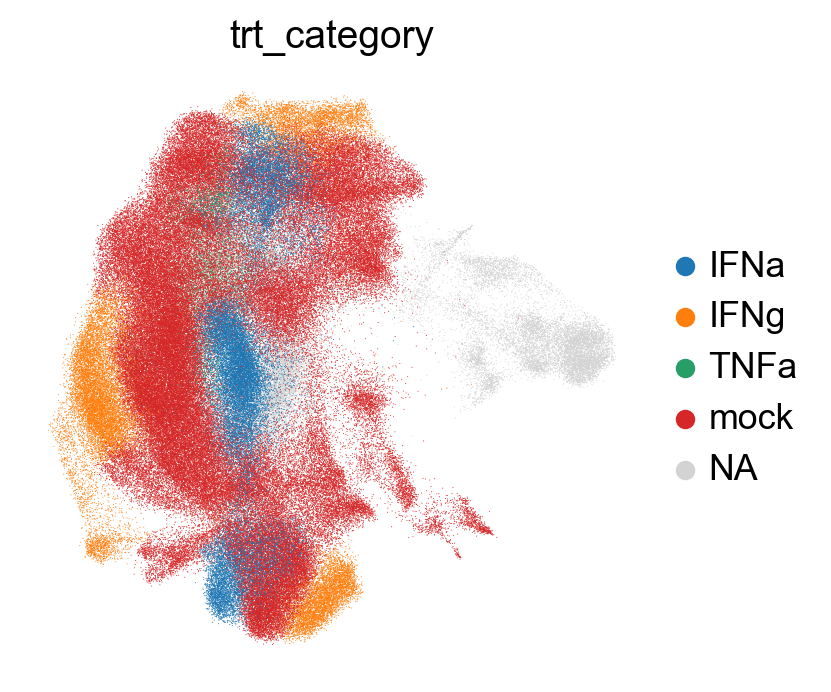

In [241]:
sc.pl.umap(adata, color='trt_category')

Check assignment:

In [242]:
pd.crosstab(adata.obs.trt_category, adata.obs.treatment)[shared_conds]

treatment     IFNa  IFNg  TGFb2   TNFa  Tirapazamine   mock
trt_category                                               
IFNa          8390   449   1209   1052           742   1482
IFNg           258  9079    310    381           332    682
TNFa           136   103    654   1290           184   1027
mock          6007  5368  12267  10554         11029  21151

Re-categorize all treatments by representation in treatment category.

In [283]:
df = pd.crosstab(adata.obs.trt_category, adata.obs.treatment)
adata.obs['trt_category'] = adata.obs.treatment.map(dict(df.idxmax()))
# store mapping as dictionary
adata.uns['trt_categories'] = adata.obs[['trt_category', 'treatment']].groupby('treatment').first().reset_index().groupby('trt_category').agg(list).to_dict()['treatment']

adata.obs[['trt_category', 'treatment']].groupby('treatment').first().sort_values('trt_category')

trt_category
treatment                        
IFNL                         IFNa
IFNa                         IFNa
IFNa + TNFa                  IFNa
IFNg                         IFNg
IFNg + TGFb2                 IFNg
TNFa + IFNg                  IFNg
BB94                         mock
Tirapazamine                 mock
TNFa + Tirapazamine          mock
TNFa + TGFb2                 mock
TNFa                         mock
Sorafenib                    mock
TGFb2                        mock
mock                         mock
Gilteritinib                 mock
DMSO                         mock
TGFb2 + Tirapazamine         mock
nan                          mock

In [285]:
adata.write('2301_annot_patient_integrated_ambient_removed.h5ad')

## Count number of and plot significant DEGs between categories

For the rest of the analysis, we'll only use the uninfected cells as to avoid infection-specific effects of the cytokines.

In [30]:
adata = adata[adata.obs.infected == 'False']

In [31]:
adata

View of AnnData object with n_obs × n_vars = 90998 × 18115
    obs: 'identifier', 'patient', 'name', 'barcode_round', 'sample', 'viral_counts', 'treatment', 'treatment_virus', 'infected', 'n_counts', 'n_genes', 'percent_mito', 'percent_viral', 'leiden', 'final_bcs', 'batch', 'celltype_coarse', 'cell_type', 'infection_label', '_scvi_batch', '_scvi_labels', 'leiden_coarse', 'leiden_fine', 'leiden_subset', 'celltype_fine', 'celltype_approx', 'ambient', 'trt_category'
    var: 'used_for_scvi'
    uns: '_scvi', 'cell_type_colors', 'celltype_approx_colors', 'celltype_coarse_colors', 'celltype_fine_colors', 'dendrogram_leiden_fine', 'hvg', 'infected_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'leiden_fine_colors', 'neighbors', 'patient_colors', 'rank_genes_groups', 'treatment_colors', 'trt_categories', 'trt_category_colors', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


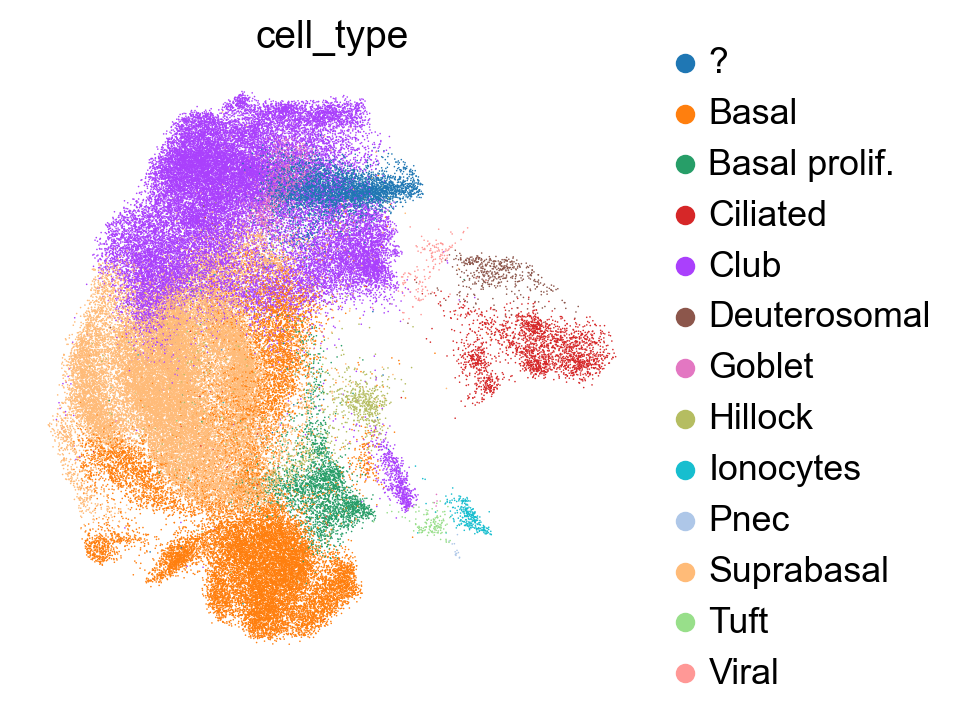

In [42]:
sc.pl.umap(adata, color='cell_type')

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


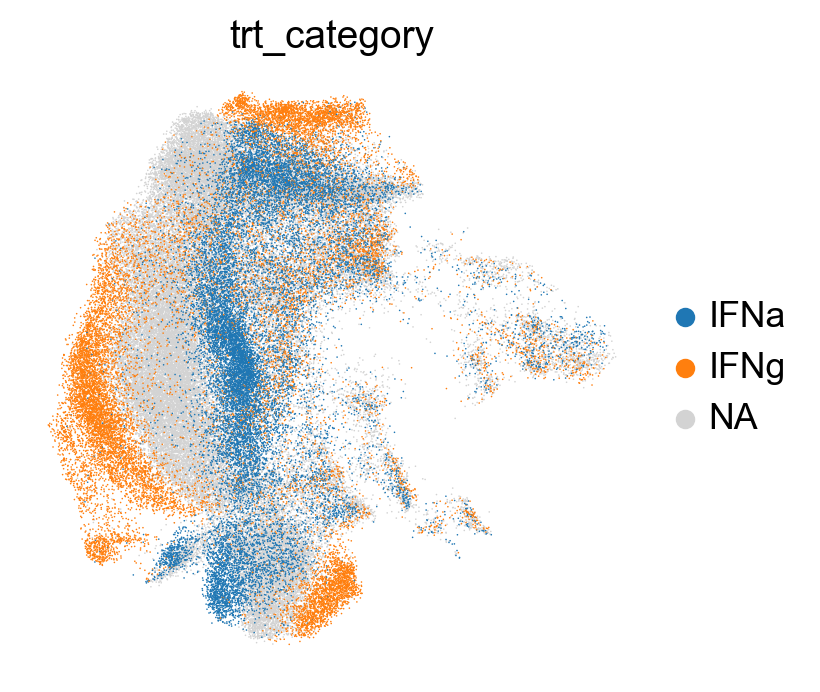

In [32]:
sc.pl.umap(adata, color='trt_category', groups=['IFNa', 'IFNg'])

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


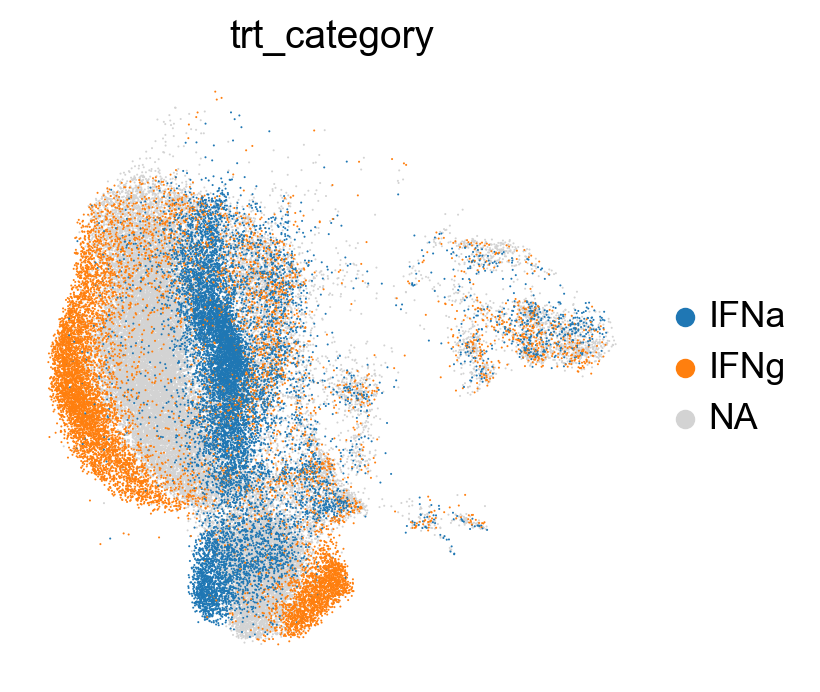

In [37]:
sc.pl.umap(adata[adata.obs.patient.isin(['Patient 3', 'Patient 4'])], color='trt_category', groups=['IFNa', 'IFNg'])

In [34]:
adata.uns['trt_categories']

{'IFNa': array(['IFNL', 'IFNa', 'IFNa + TNFa'], dtype=object),
 'IFNg': array(['IFNg', 'IFNg + TGFb2', 'TNFa + IFNg'], dtype=object),
 'mock': array(['BB94', 'DMSO', 'Gilteritinib', 'Sorafenib', 'TGFb2',
        'TGFb2 + Tirapazamine', 'TNFa', 'TNFa + TGFb2',
        'TNFa + Tirapazamine', 'Tirapazamine', 'mock', 'nan'], dtype=object)}

In [8]:
from utils import enrich

In [9]:
def plot_volcano(df, fc_thresh=2, logpval_thresh=50, plot=True):
    """Make a volcano plot from a rank_genes_groups dataframe.
    
    Returns
    -------
    df
        Modified dataframe with plot values.
    up_genes
        Genes with significantly increased differential expression.
    down_genes
        Genes with significantly decreased differential expression.
    """
    df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)
    df = df.replace(np.inf, 325)
    sig_up = df[(df['logfoldchanges'] > fc_thresh) & (df['-log10(pvals)'] > logpval_thresh)].copy()
    sig_down = df[(df['logfoldchanges'] < -fc_thresh) & (df['-log10(pvals)'] > logpval_thresh)].copy()

    if plot:
        # grey - not significant
        plt.scatter(df['logfoldchanges'].values, df['-log10(pvals)'].values, s=4, c='grey')
        # red - up and significant
        plt.scatter(sig_up['logfoldchanges'].values, sig_up['-log10(pvals)'].values, s=4, c='darkred')
        # blue - down and significant
        plt.scatter(sig_down['logfoldchanges'].values, sig_down['-log10(pvals)'].values, s=4)

        plt.xlabel('logFC')
        plt.ylabel('-log10(pvals)')
        plt.xlim(-7, 7)  # to avoid plotting super high FC genes caused by dropout
    return df, sig_up.names.values, sig_down.names.values

In [35]:
sc.tl.rank_genes_groups(adata, groupby='trt_category', reference='mock')

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


Volcano plots for general, non-celltype specific DEGs, using only patients 3 and 4 which contained all relevant treatments.

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


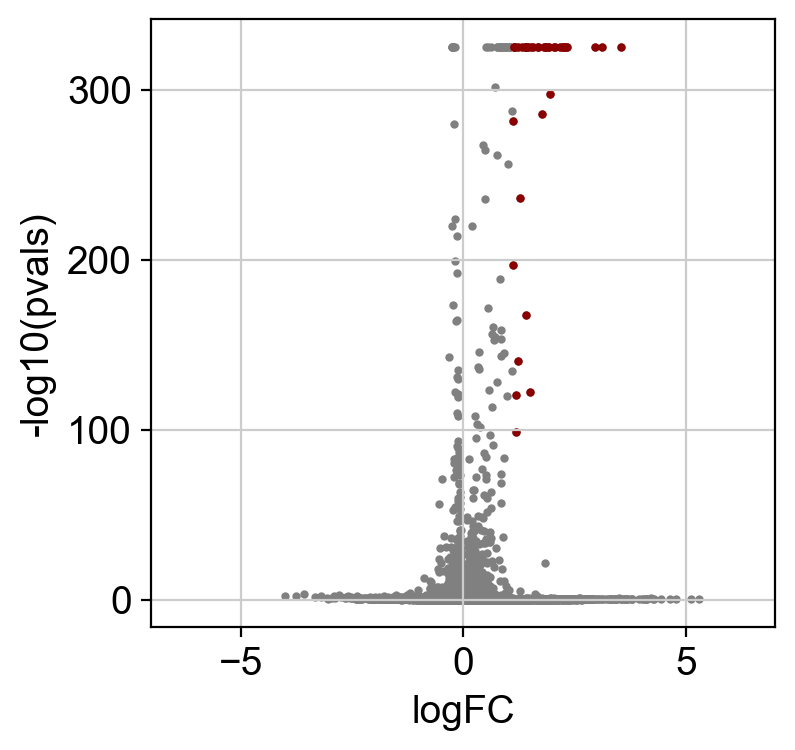

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


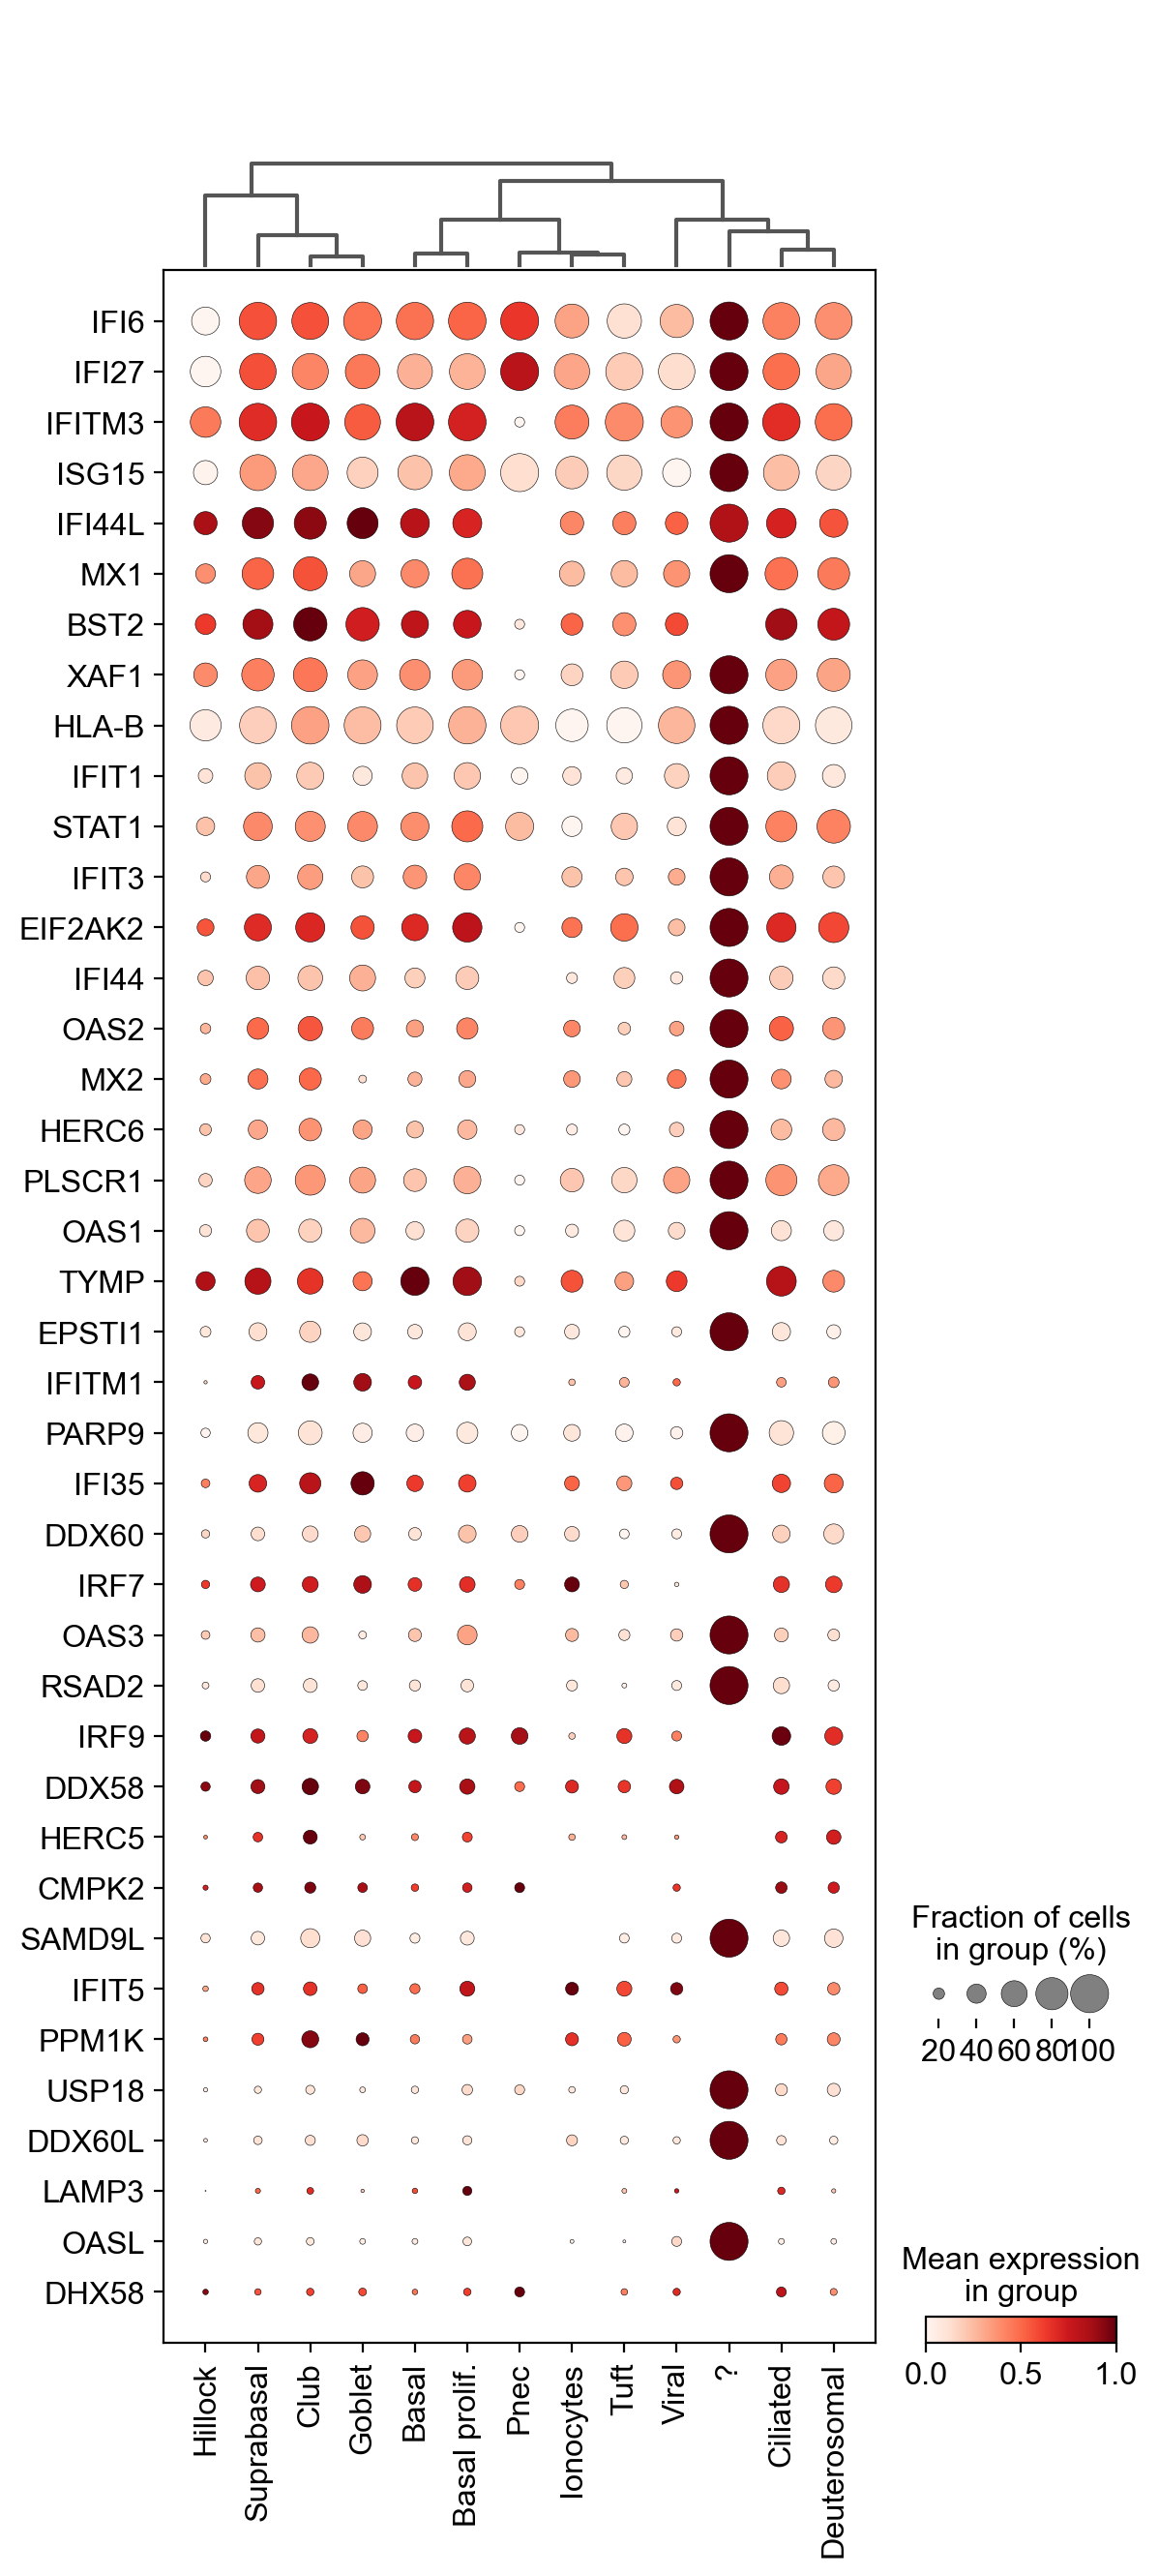

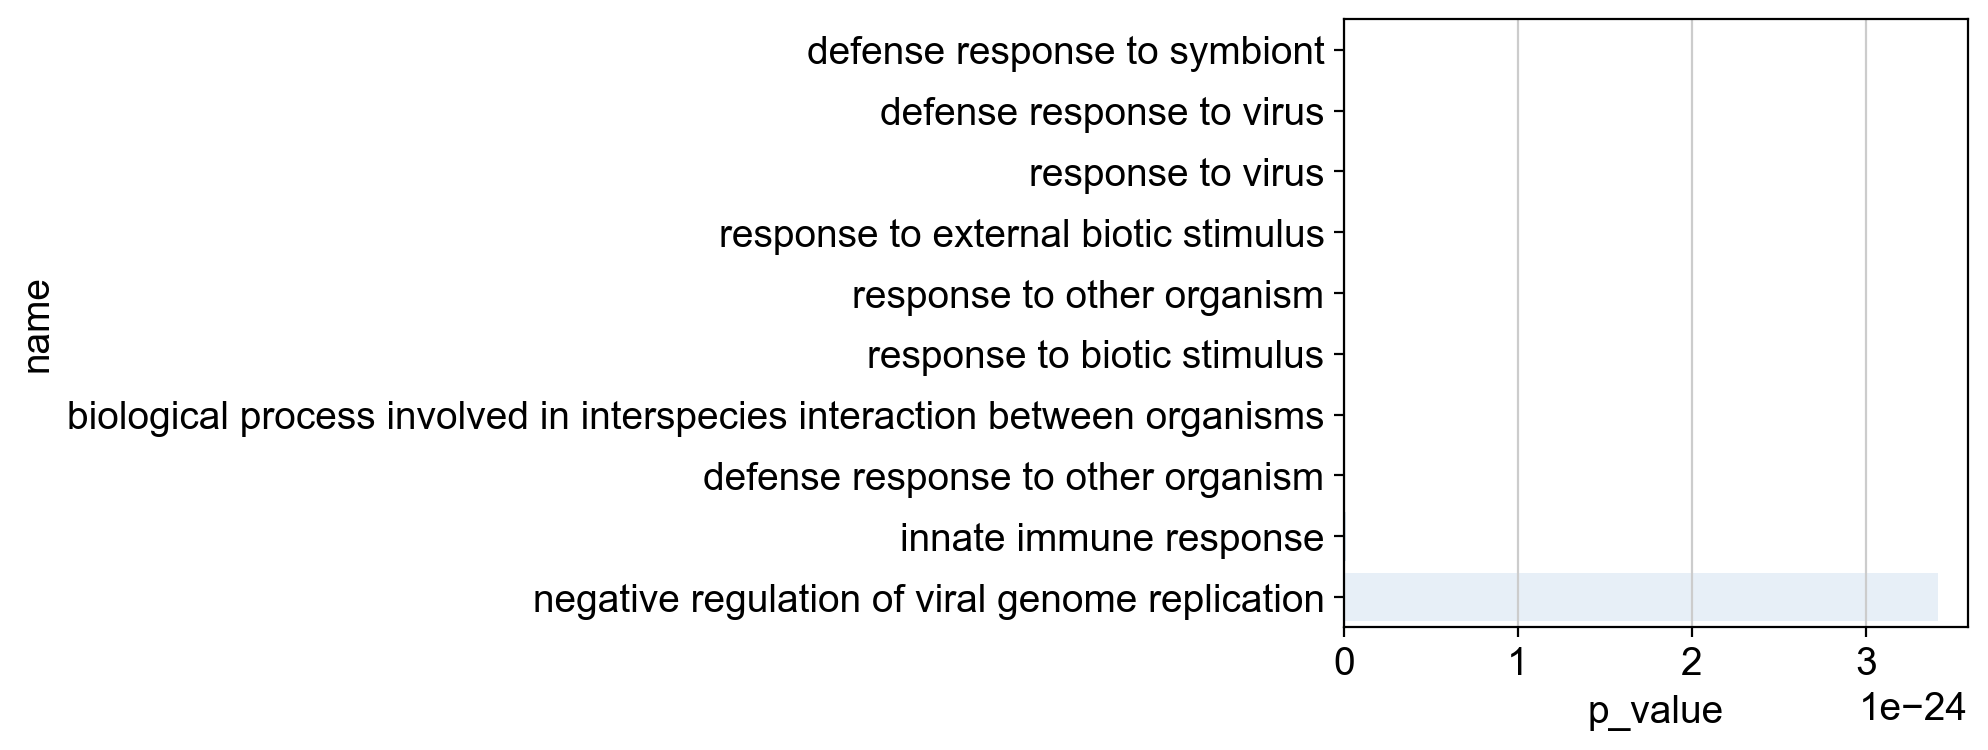

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


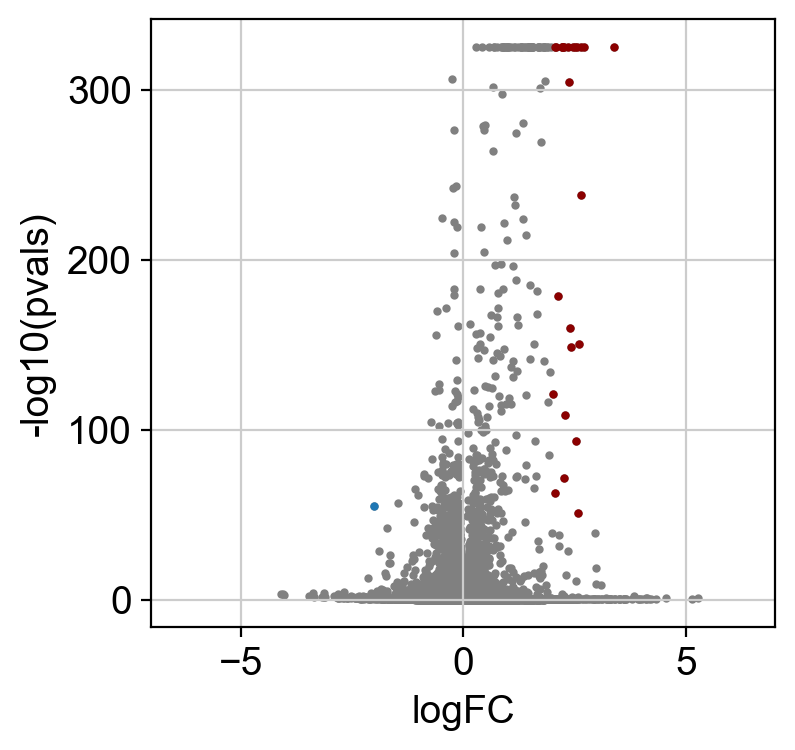

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


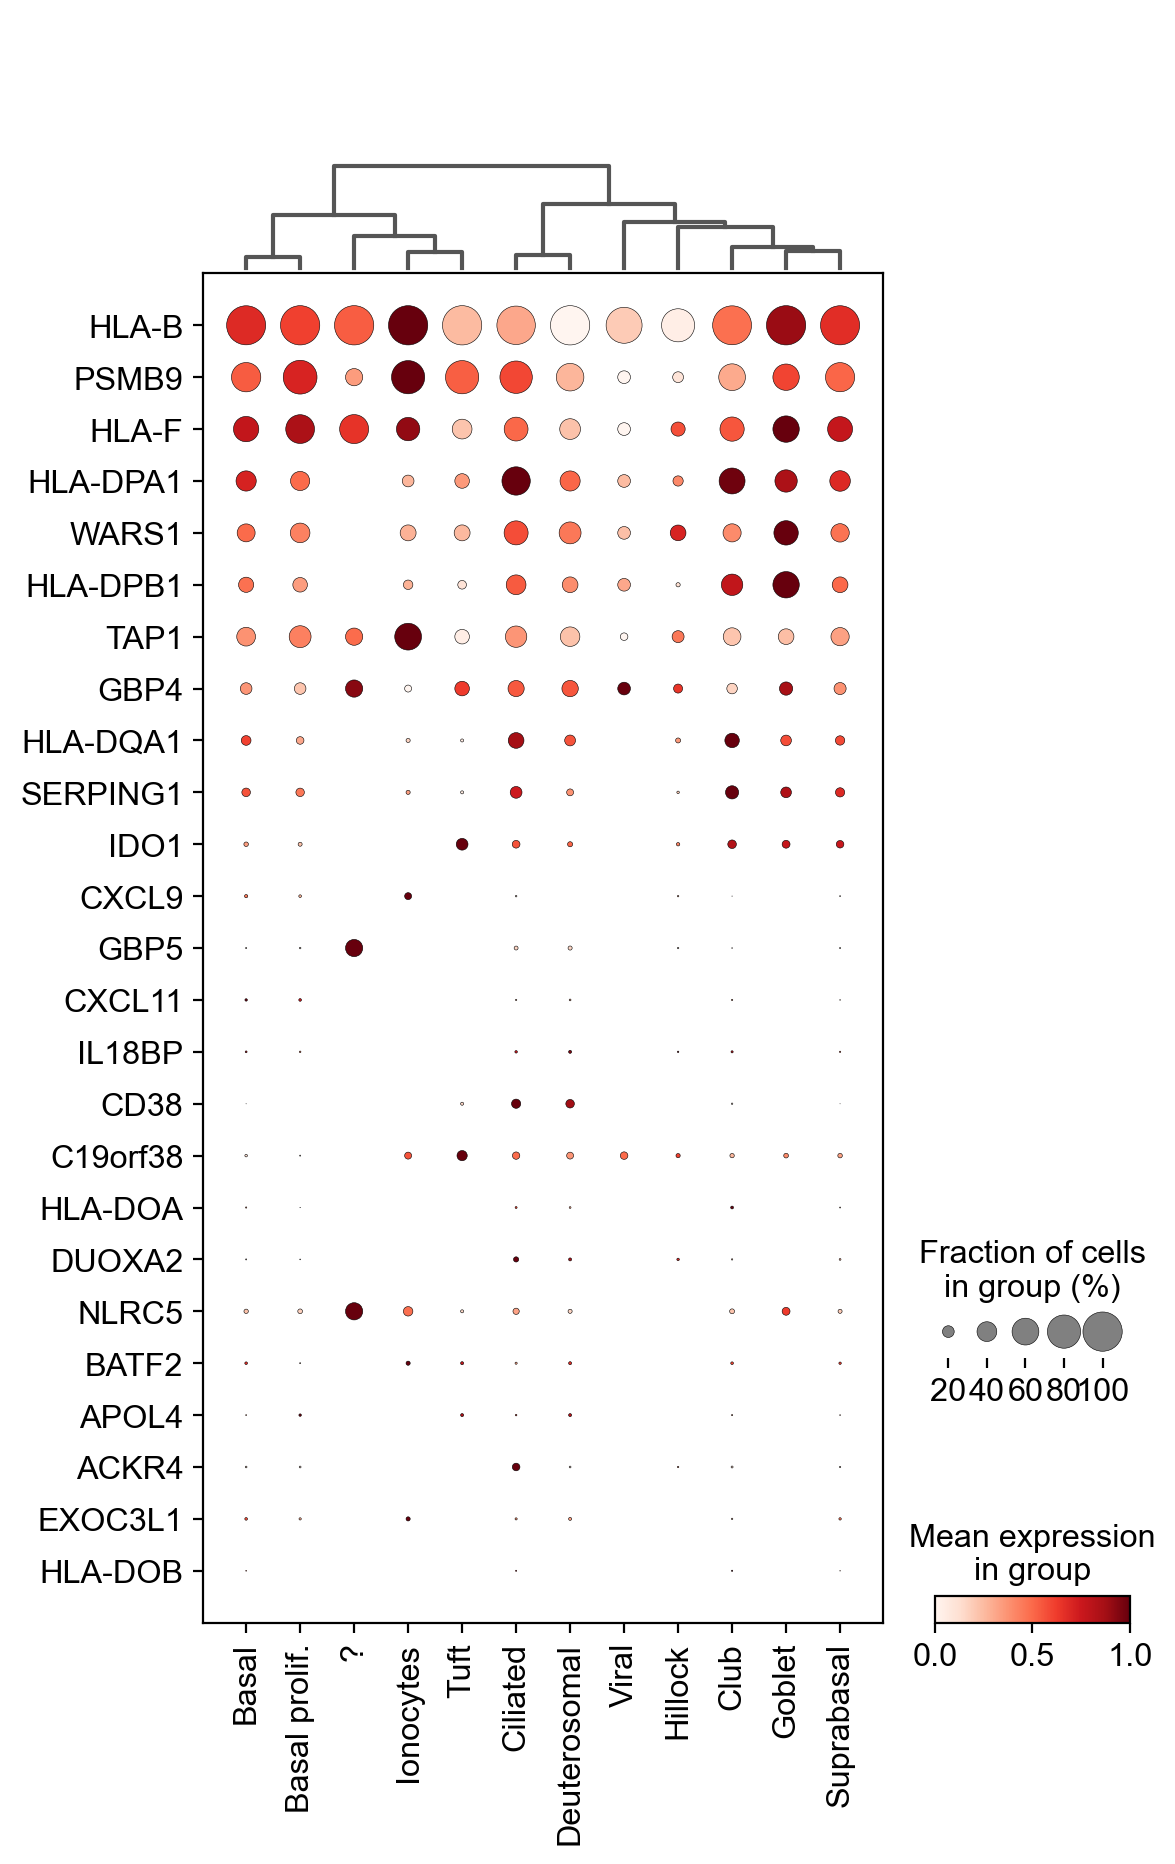

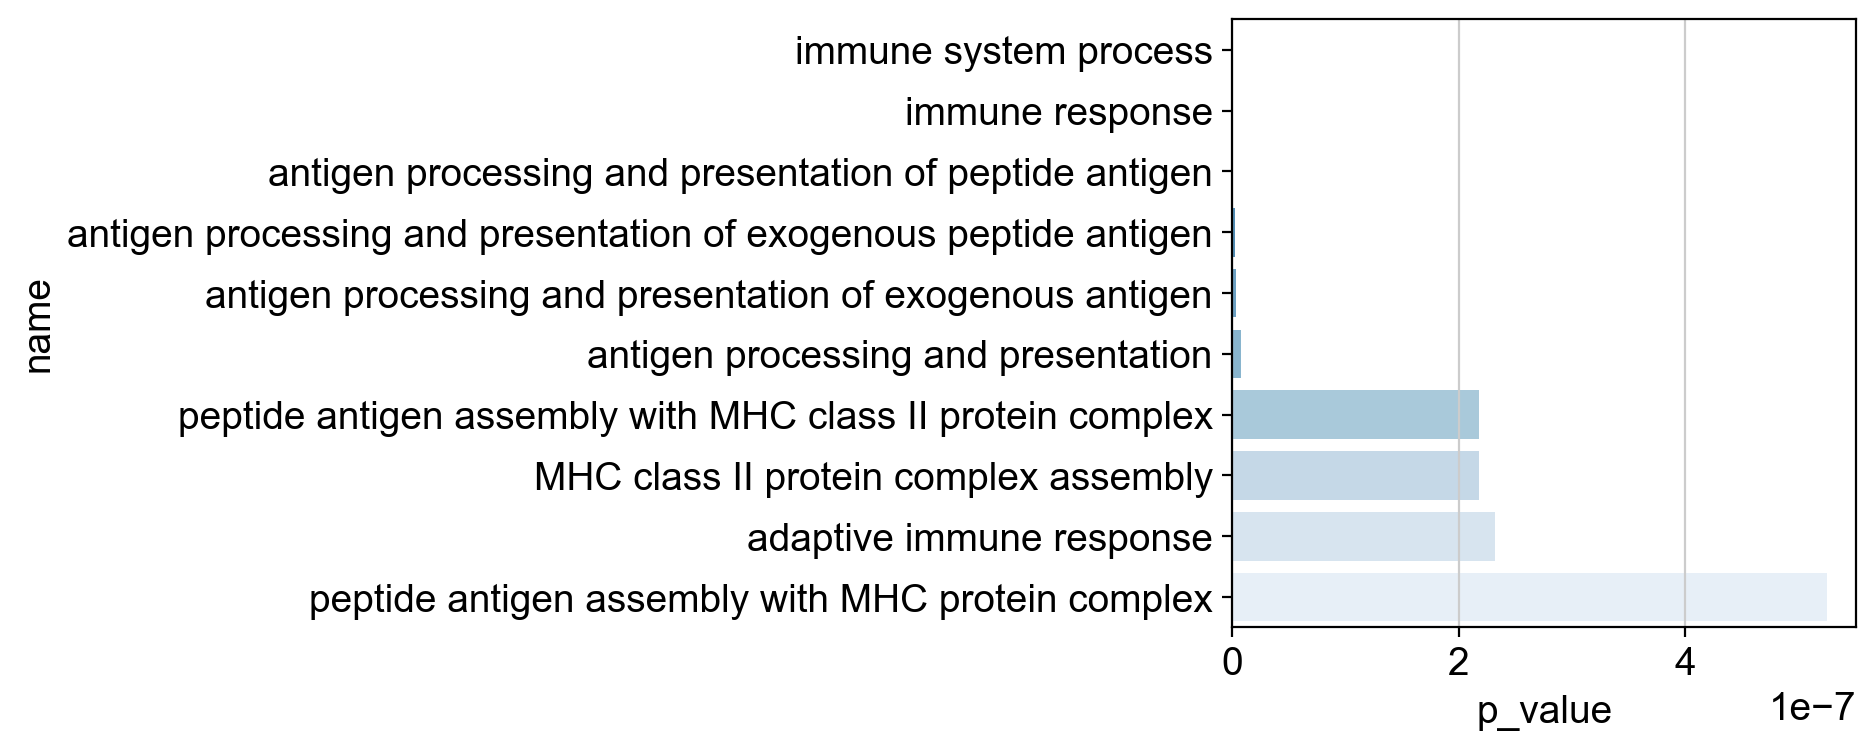

In [36]:
for cat, thresh in zip(['IFNa', 'IFNg'], [1.1, 2]):
    df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(adata, group=cat), fc_thresh=thresh)
    plt.show()

#     for trt in adata.uns['trt_categories'][cat]:
#         sc.pl.dotplot(adata[adata.obs.treatment == trt], var_names=up, groupby='cell_type', standard_scale='var', title=trt)

    sc.pl.dotplot(
        adata[(adata.obs.treatment.isin(adata.uns['trt_categories'][cat])) & (adata.obs.patient.isin(['Patient 3', 'Patient 4']))],
        var_names=up, groupby='cell_type', standard_scale='var', swap_axes=True, dendrogram=True
    )

    sns.barplot(data=enrich(up, adata.var_names).head(10), x='p_value', y='name', palette='Blues_r')
    plt.show()

Calculate DEGs per cell type (if there are any):

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


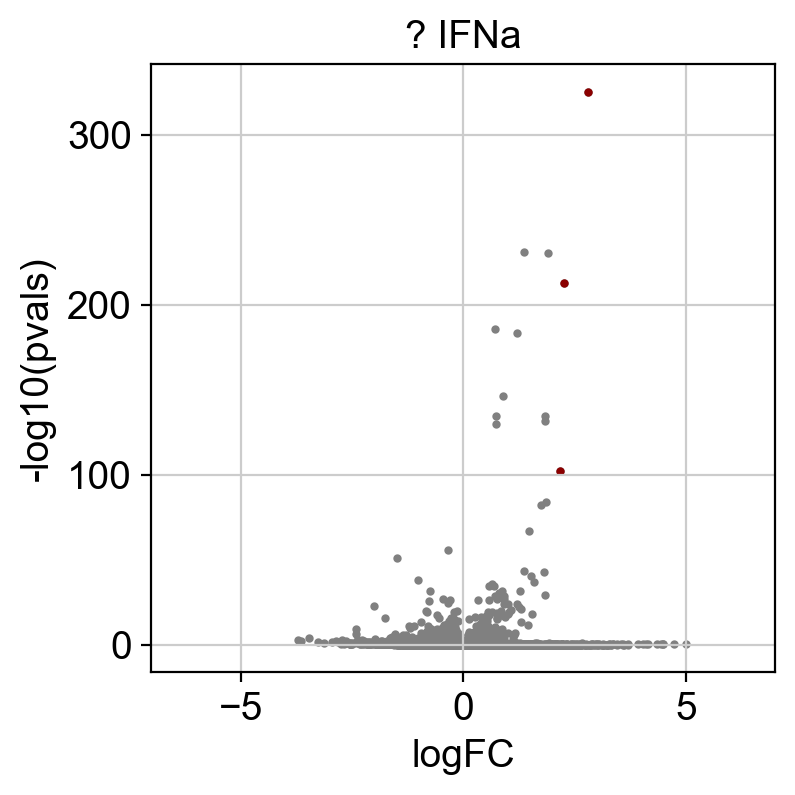

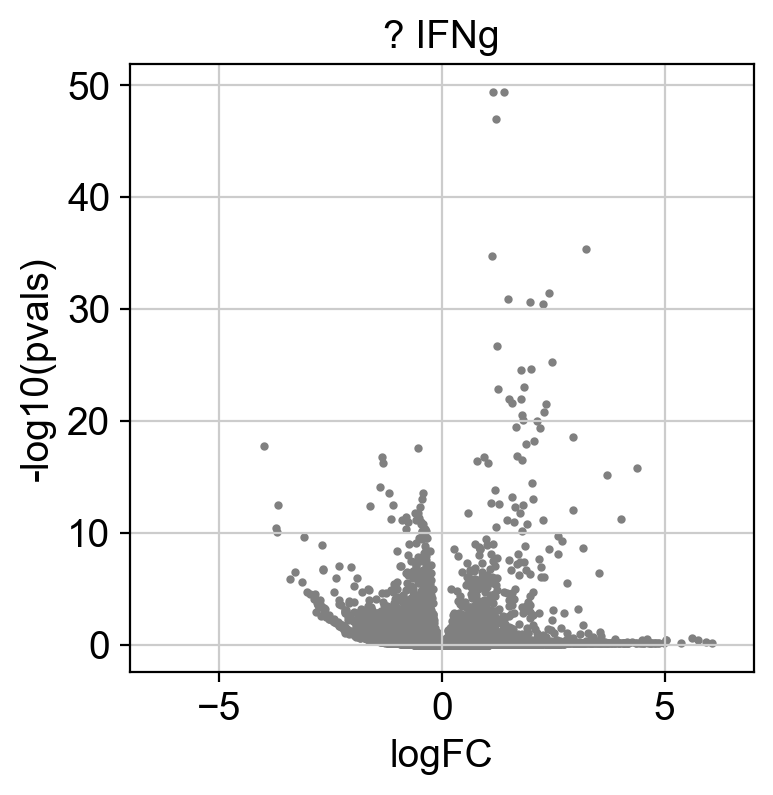

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


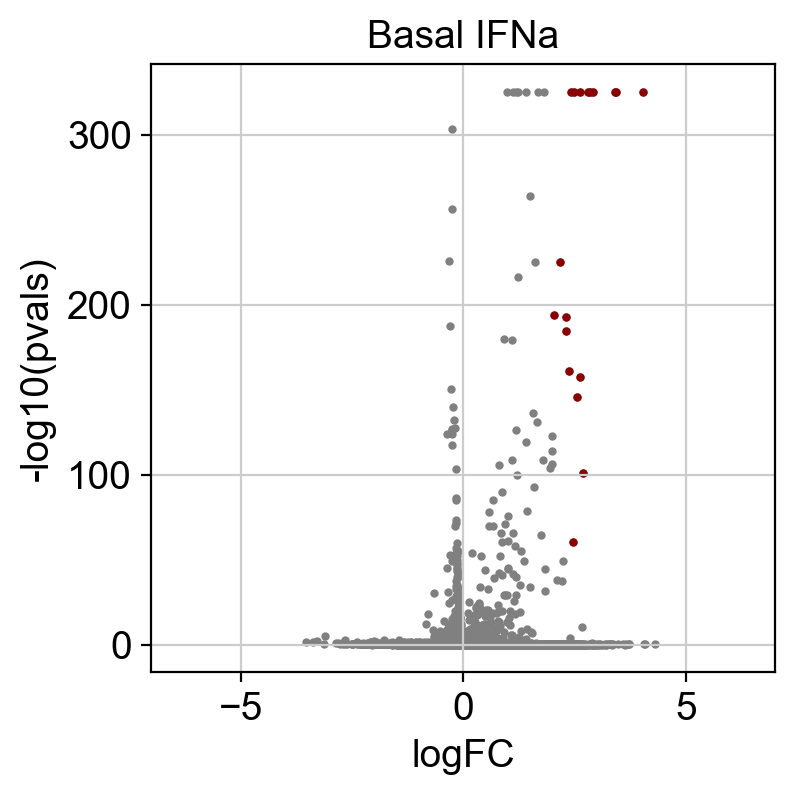

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


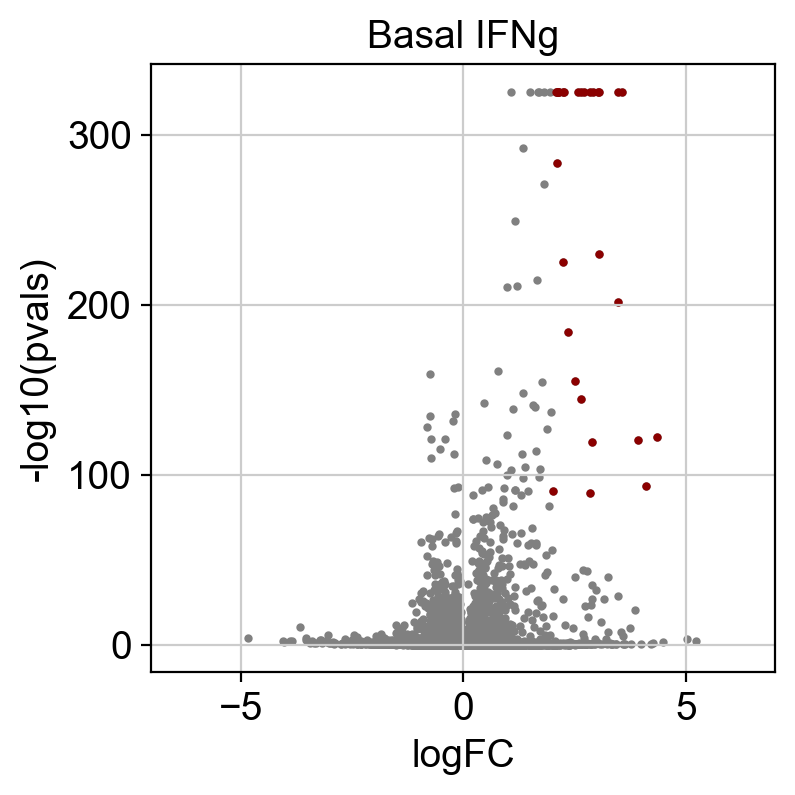

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


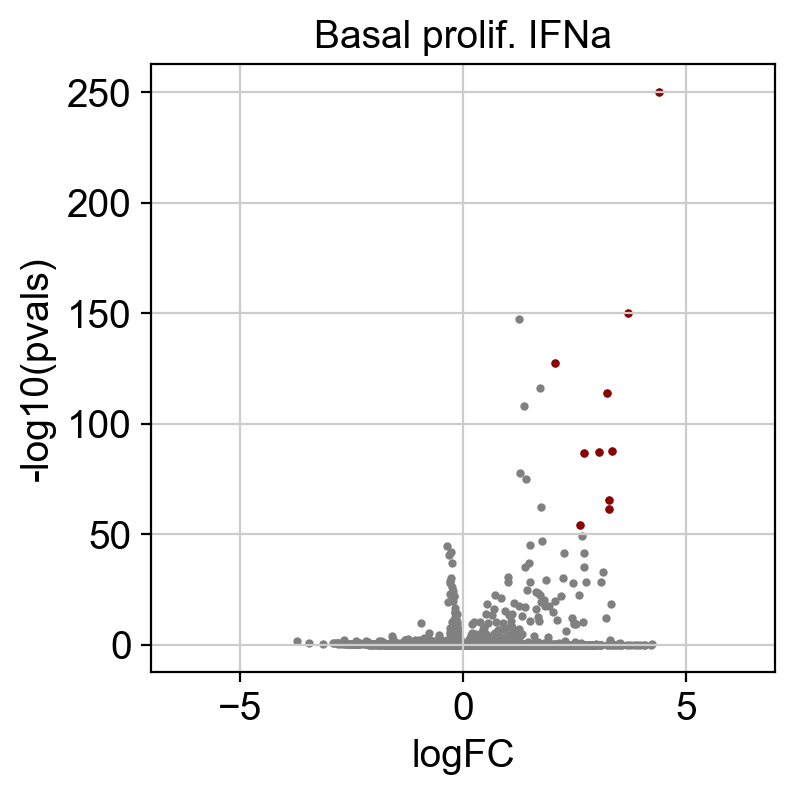

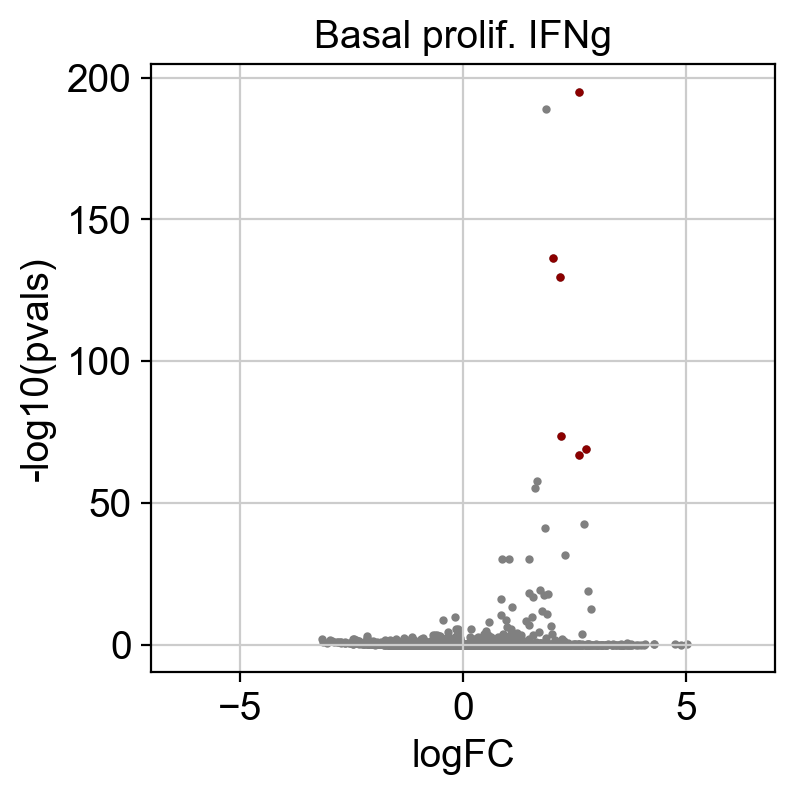

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


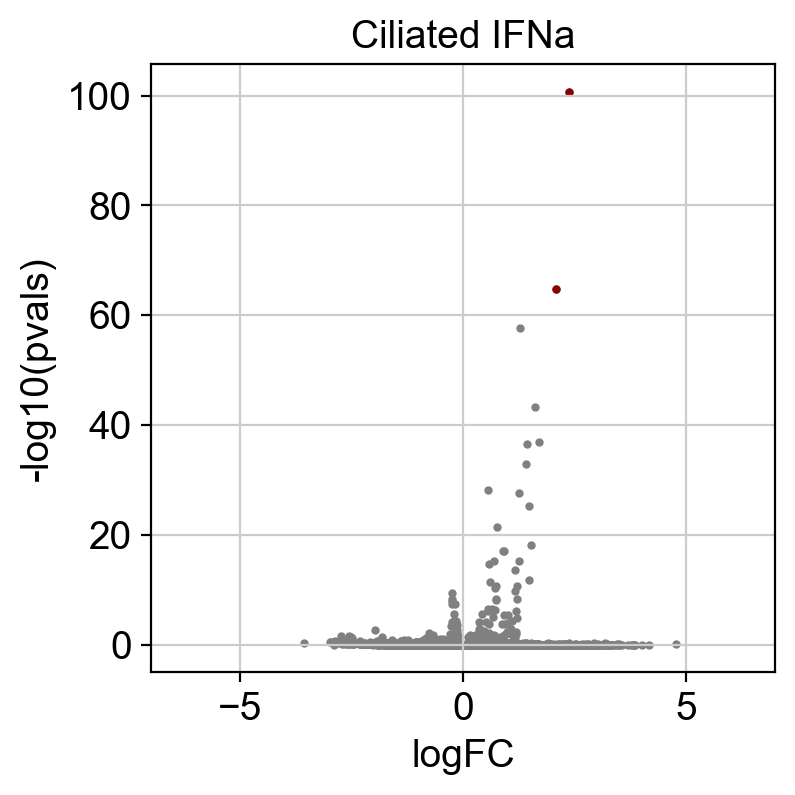

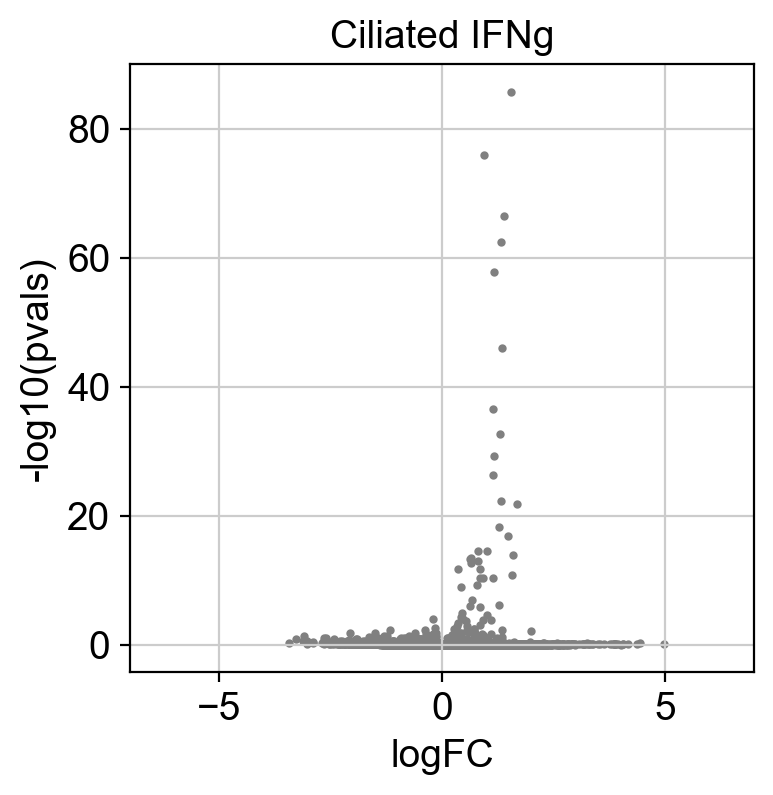

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


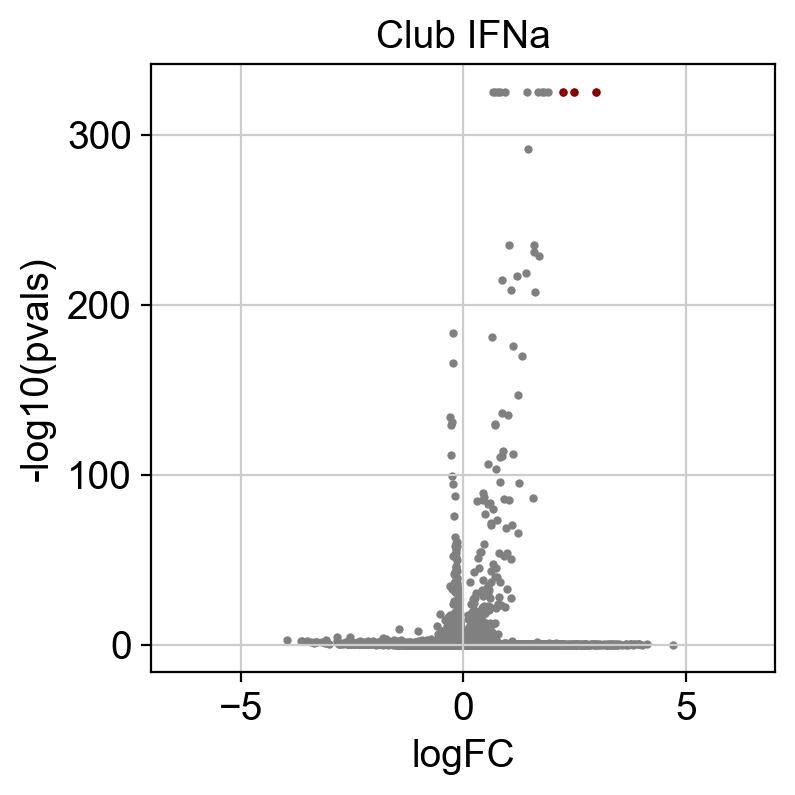

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


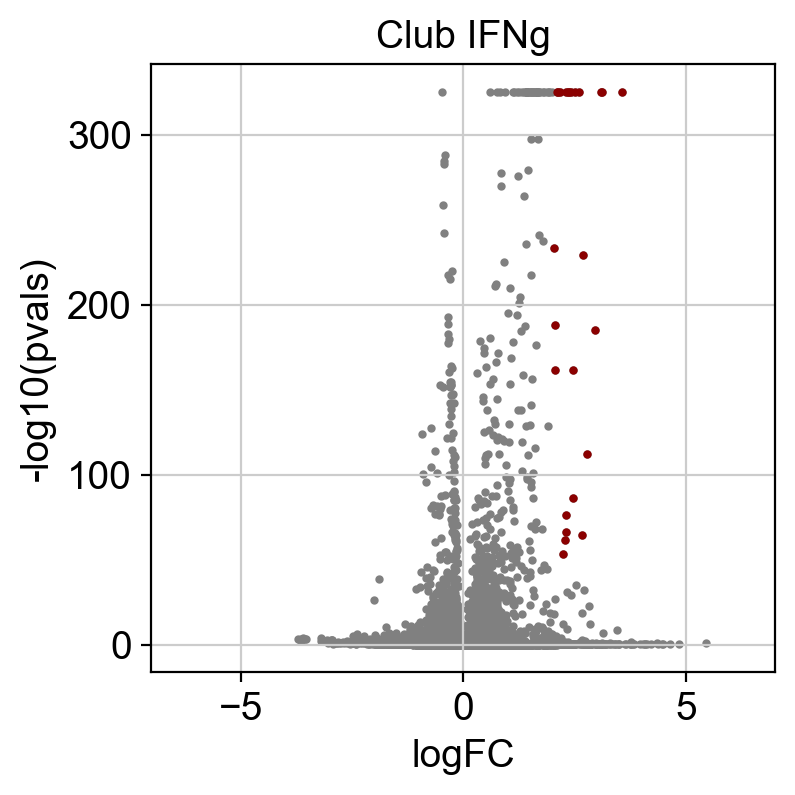

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


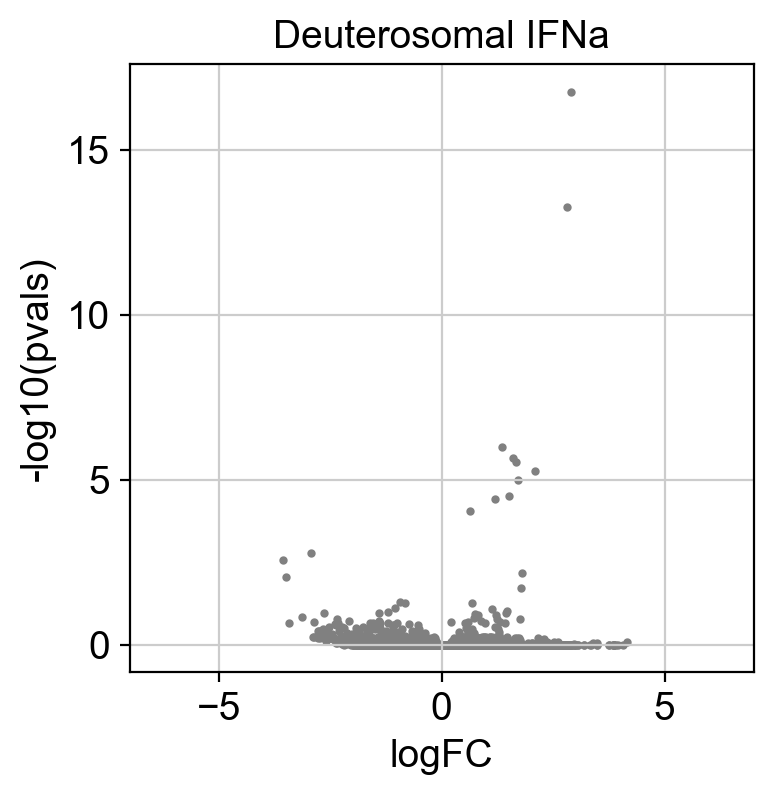

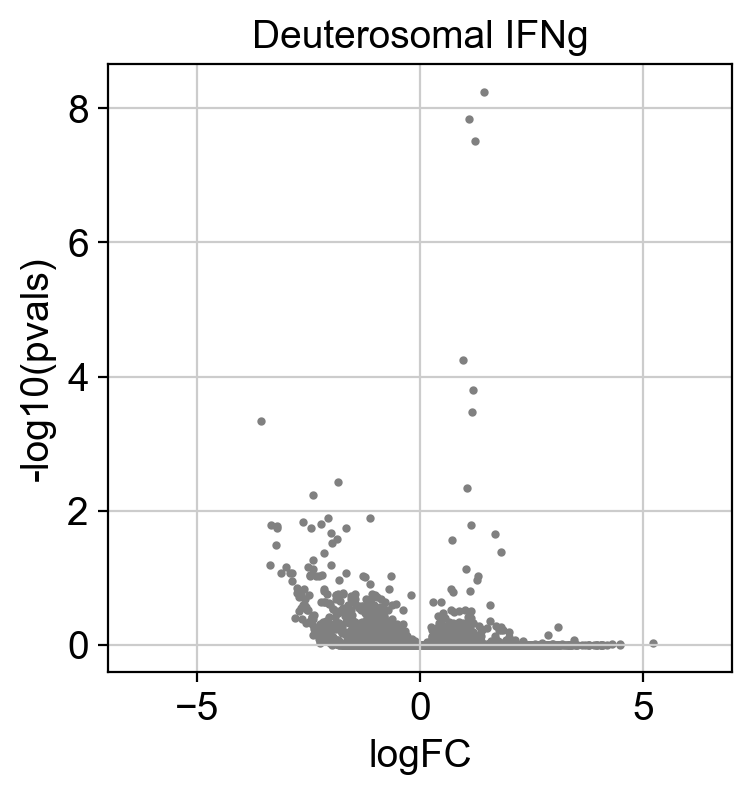

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


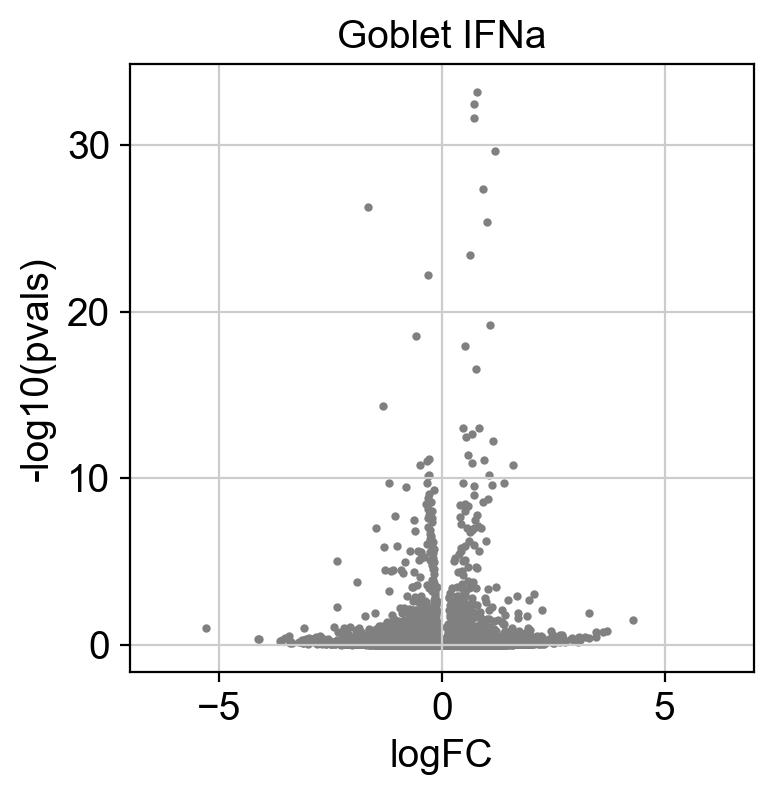

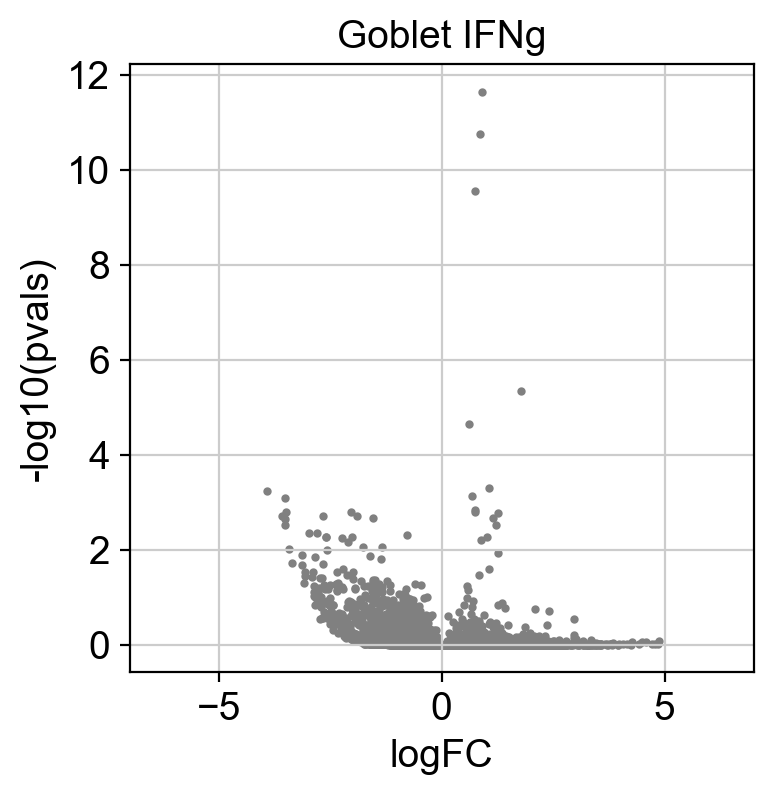

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


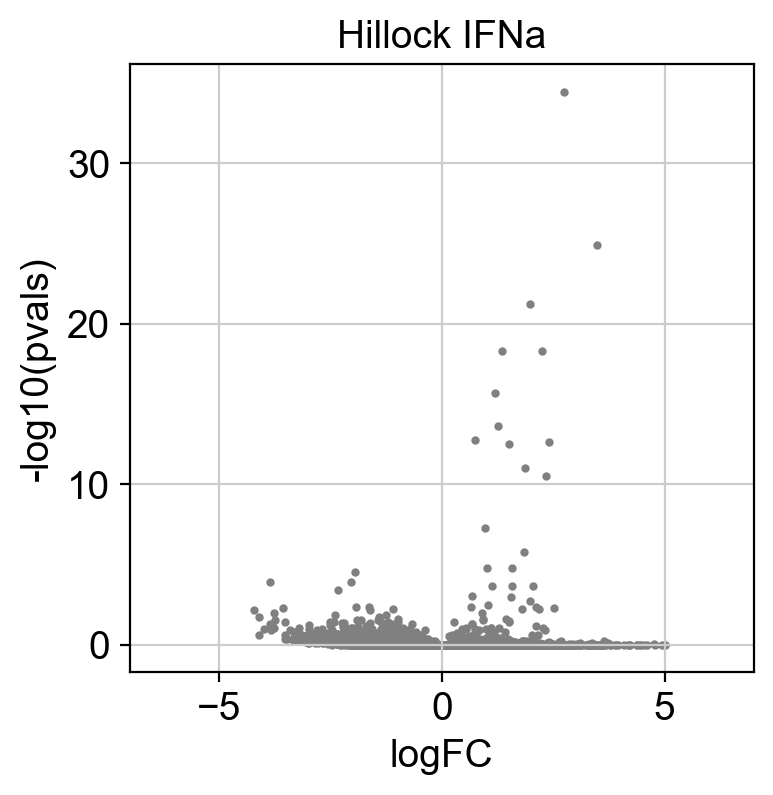

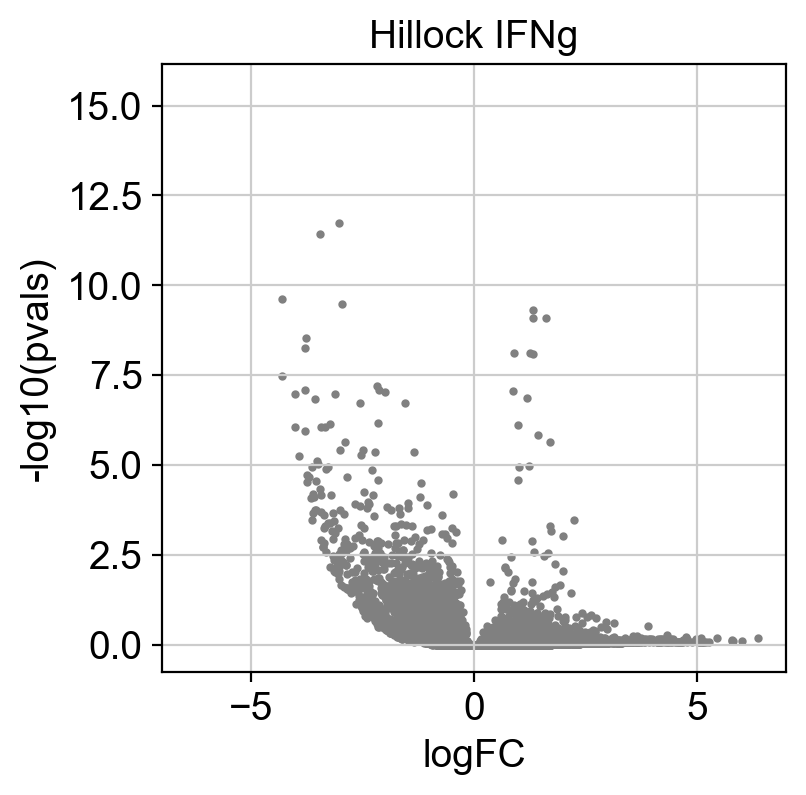

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


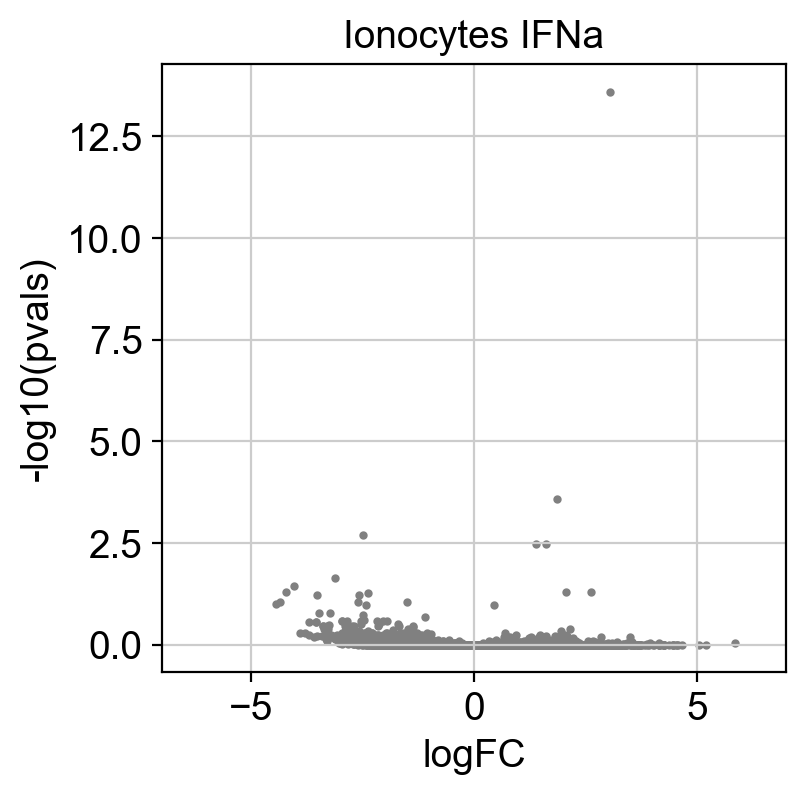

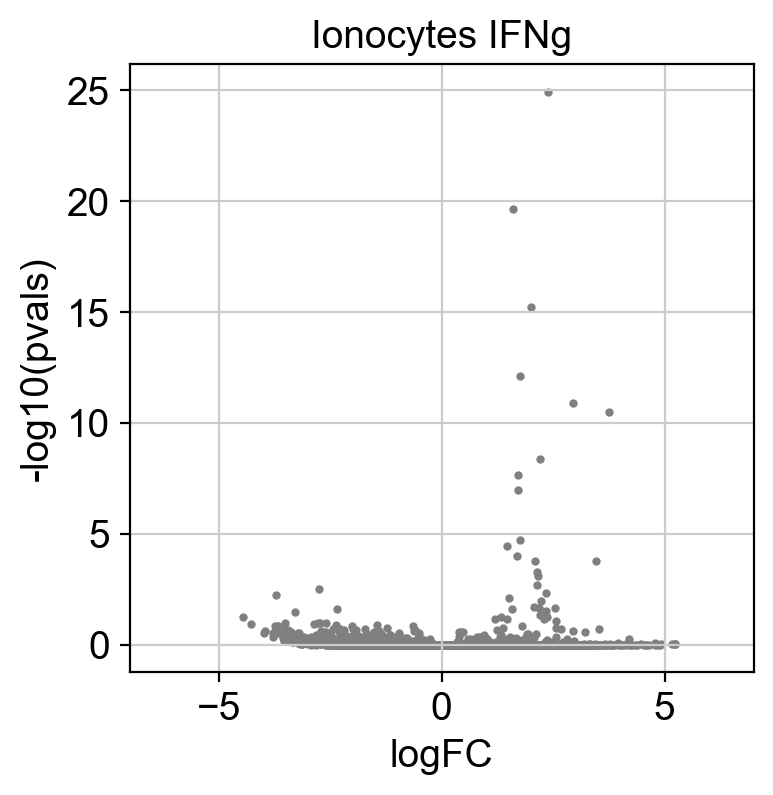

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


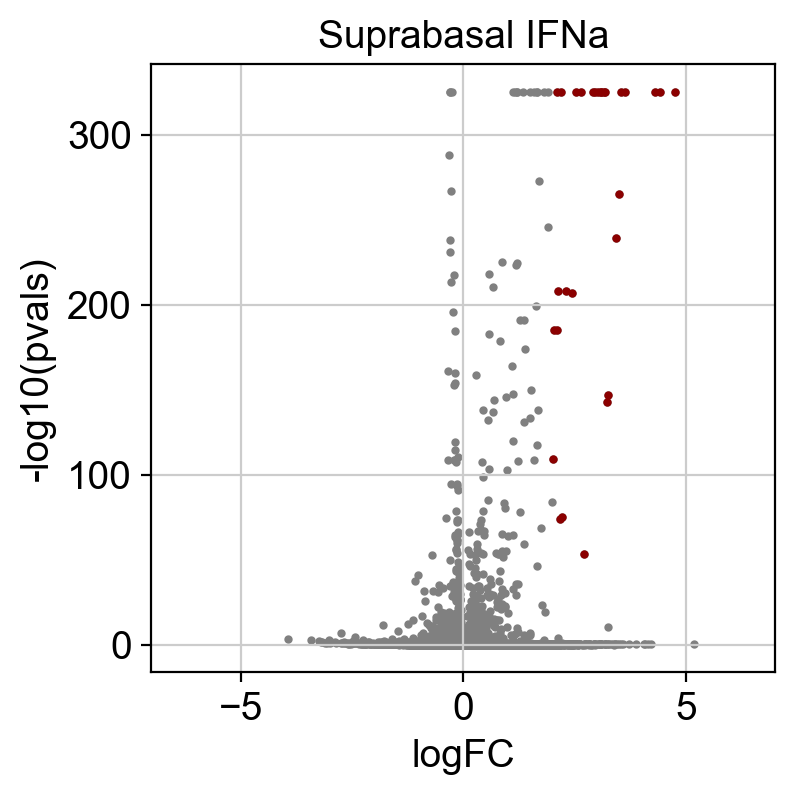

/var/folders/v6/zs1gvsy159l1hq7s2sglwz2ncvz45z/T/ipykernel_97152/311615840.py:13: RuntimeWarning: divide by zero encountered in log10
  df['-log10(pvals)'] = -np.log10(df.pvals_adj.values)


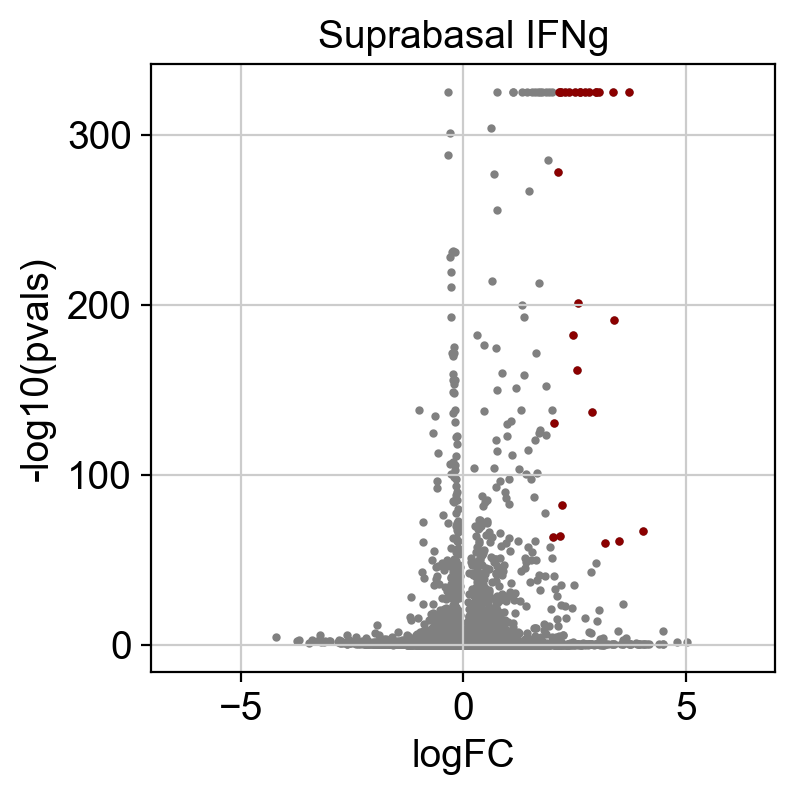

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


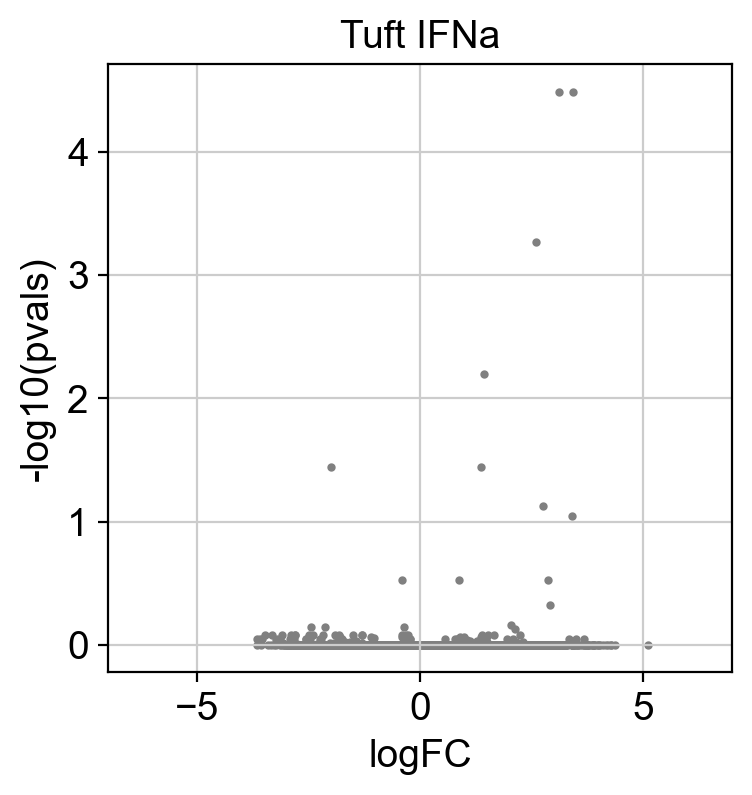

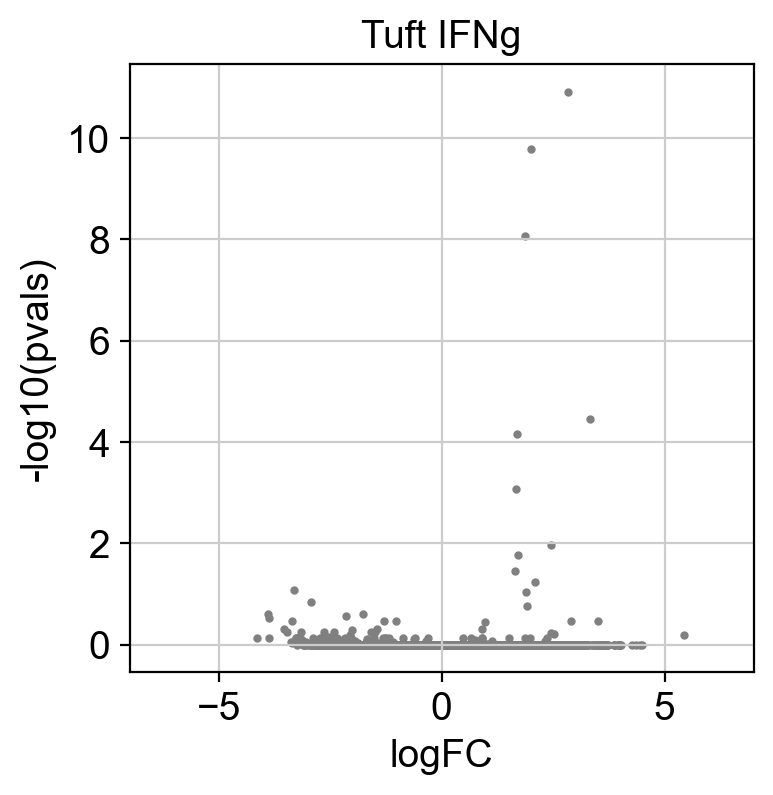

/Users/yuge.ji/miniconda3/envs/py38_analysis/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


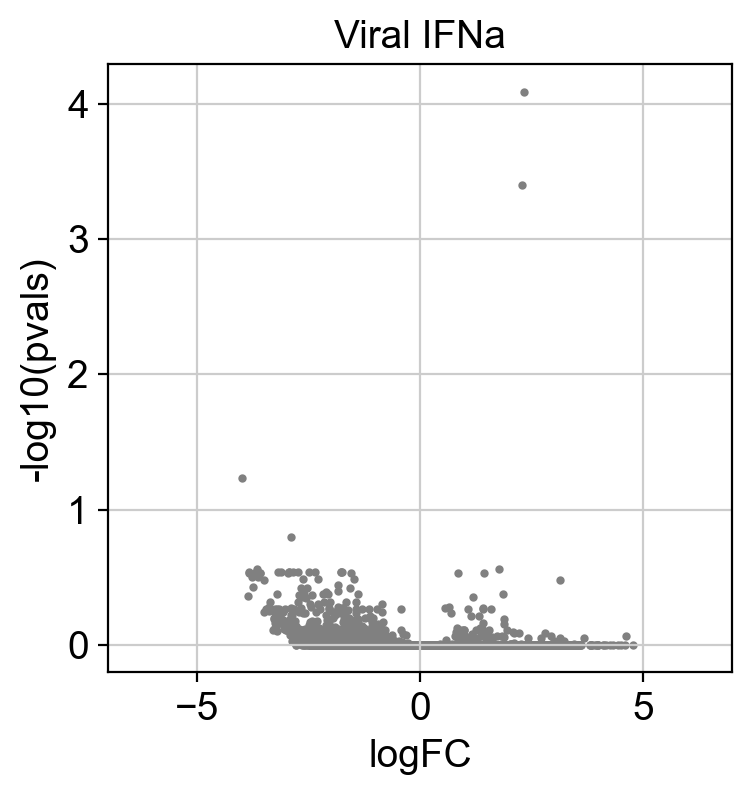

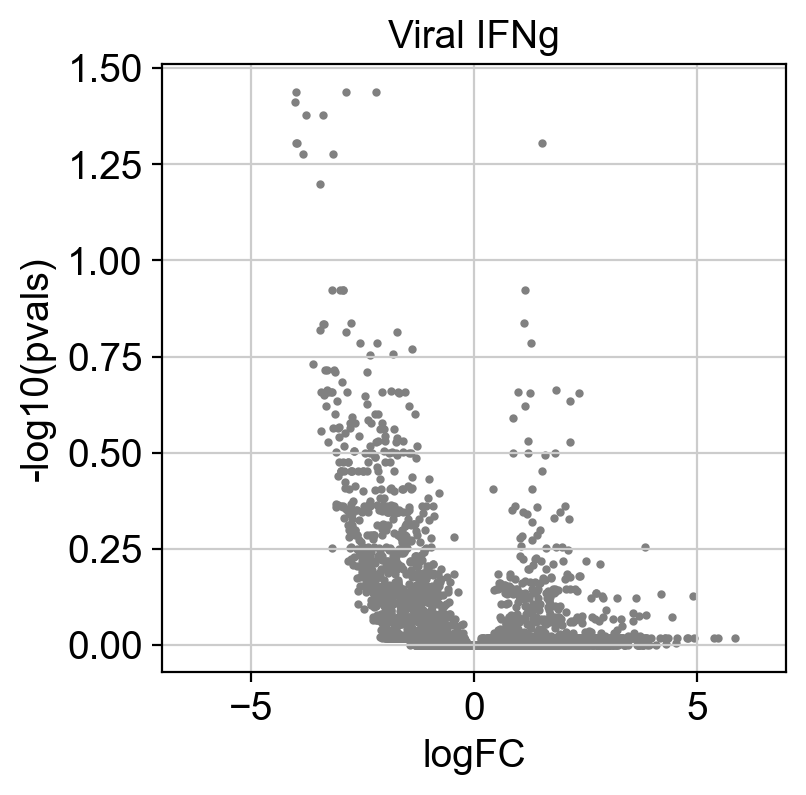

In [45]:
ndegs = {
    'IFNa': {},
    'IFNg': {}
}
for ct in adata.obs.cell_type.cat.categories:
    subset = adata[adata.obs.cell_type == ct]
    if subset.shape[0] < 50:  # don't calculate for fewer than 50 cells
        continue
    sc.tl.rank_genes_groups(subset, groupby='trt_category', reference='mock')
    for cat in ['IFNa', 'IFNg']:
        df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(subset, group=cat), fc_thresh=2)
        plt.title(ct + ' ' + cat)
        plt.show()

#         if len(up) + len(dn) > 5:
#             print(ct, cat, len(up)+len(dn), up)
                
        ndegs[cat][ct] = len(up)+len(dn)

In [46]:
pd.DataFrame.from_dict(ndegs)

IFNa  IFNg
?                 3     0
Basal            18    29
Basal prolif.    10     6
Ciliated          2     0
Club              3    25
Deuterosomal      0     0
Goblet            0     0
Hillock           0     0
Ionocytes         0     0
Suprabasal       29    28
Tuft              0     0
Viral             0     0

In [50]:
pd.DataFrame.from_dict(ndegs, orient='index')[['Basal', 'Basal prolif.', 'Club', 'Suprabasal']].T.mean()

IFNa    15.0
IFNg    22.0
dtype: float64

In [40]:
pd.crosstab([adata.obs.trt_category, adata.obs.patient], adata.obs.cell_type)

cell_type                  ?  Basal  Basal prolif.  Ciliated   Club  \
trt_category patient                                                  
IFNa         Patient 1   216    408              7         3   2841   
             Patient 2   762    345              5         6   1217   
             Patient 3     1   2056            321        66    676   
             Patient 4     0   1325            240       347    696   
IFNg         Patient 1    71    608              1         6   2402   
             Patient 2   114    305              2         4   1759   
             Patient 3     2   2339            206        63    521   
             Patient 4     1   1625            150       365    433   
mock         Patient 1  1059    849             25        29  10223   
             Patient 2  2243    584             11        14   3661   
             Patient 3     4   4798            699       112   2151   
             Patient 4     5   4270            848      1190   3415   

cell_type               Deuterosomal  Goblet  Hillock  Ionocytes  Pnec  \
trt_category patient                                                     
IFNa         Patient 1             3      77       79         27     1   
             Patient 2             5     470       15          4     0   
             Patient 3            34      15       20         17     4   
             Patient 4            42      10      110          4     2   
IFNg         Patient 1             2      30        9         23     0   
             Patient 2             3      30        8         19     1   
             Patient 3            27       6       11         14     0   
             Patient 4            34      11       67          6     0   
mock         Patient 1            23     166      184         86     0   
             Patient 2            15     176      104         31     0   
             Patient 3           106      16       63         40     2   
             Patient 4           164      34      347         25     3   

cell_type               Suprabasal  Tuft  Viral  
trt_category patient                             
IFNa         Patient 1         227     4      9  
             Patient 2          92     0     11  
             Patient 3        3550    18     10  
             Patient 4        2099    13      8  
IFNg         Patient 1         603     4     11  
             Patient 2         195     3      3  
             Patient 3        2681    16      6  
             Patient 4        1739    14      3  
mock         Patient 1        1269     7     41  
             Patient 2         897     1     18  
             Patient 3        9552    37     21  
             Patient 4        6247    40     19

### examine individual treatments not included bc they need lower thresholding for less effect

In [353]:
subset = adata[adata.obs.patient.isin(['Patient 1', 'Patient 2'])]
sc.tl.rank_genes_groups(subset, groupby='treatment', reference='mock')

/home/yuge/miniconda3/envs/fa_base/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [359]:
enrich(up, subset.var_names).head(10)

Empty DataFrame
Columns: [name, p_value, intersections]
Index: []

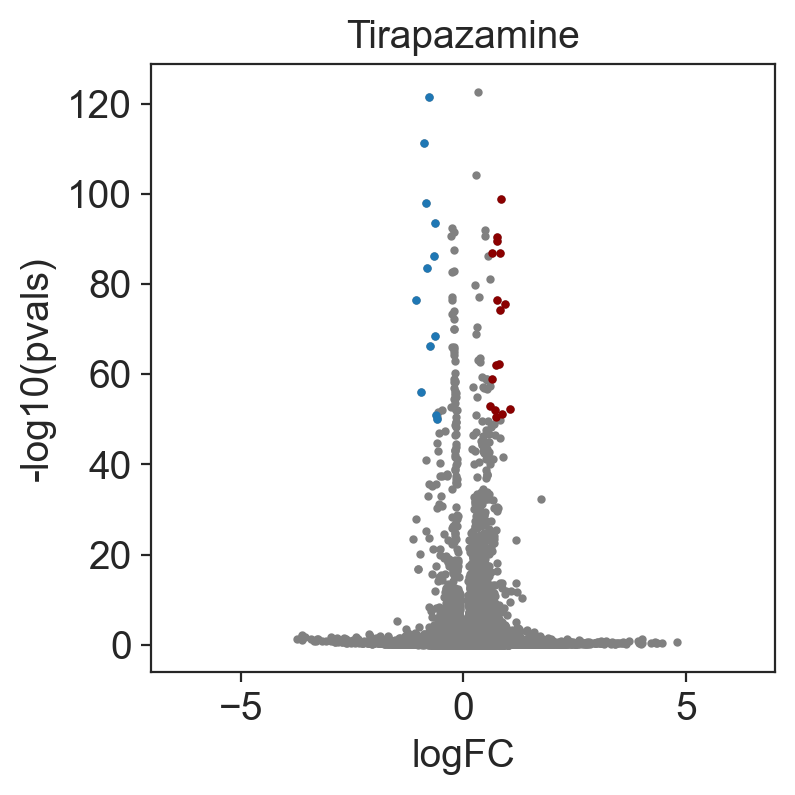

['ISG15' 'MX1' 'IFI6' 'IFIT3' 'C15orf48' 'IFI44L' 'IFIT2' 'IFIT1' 'MX2'
 'CST6' 'IFI27' 'SAMD9' 'HERC5' 'OAS3' 'CMPK2' 'IFIH1']


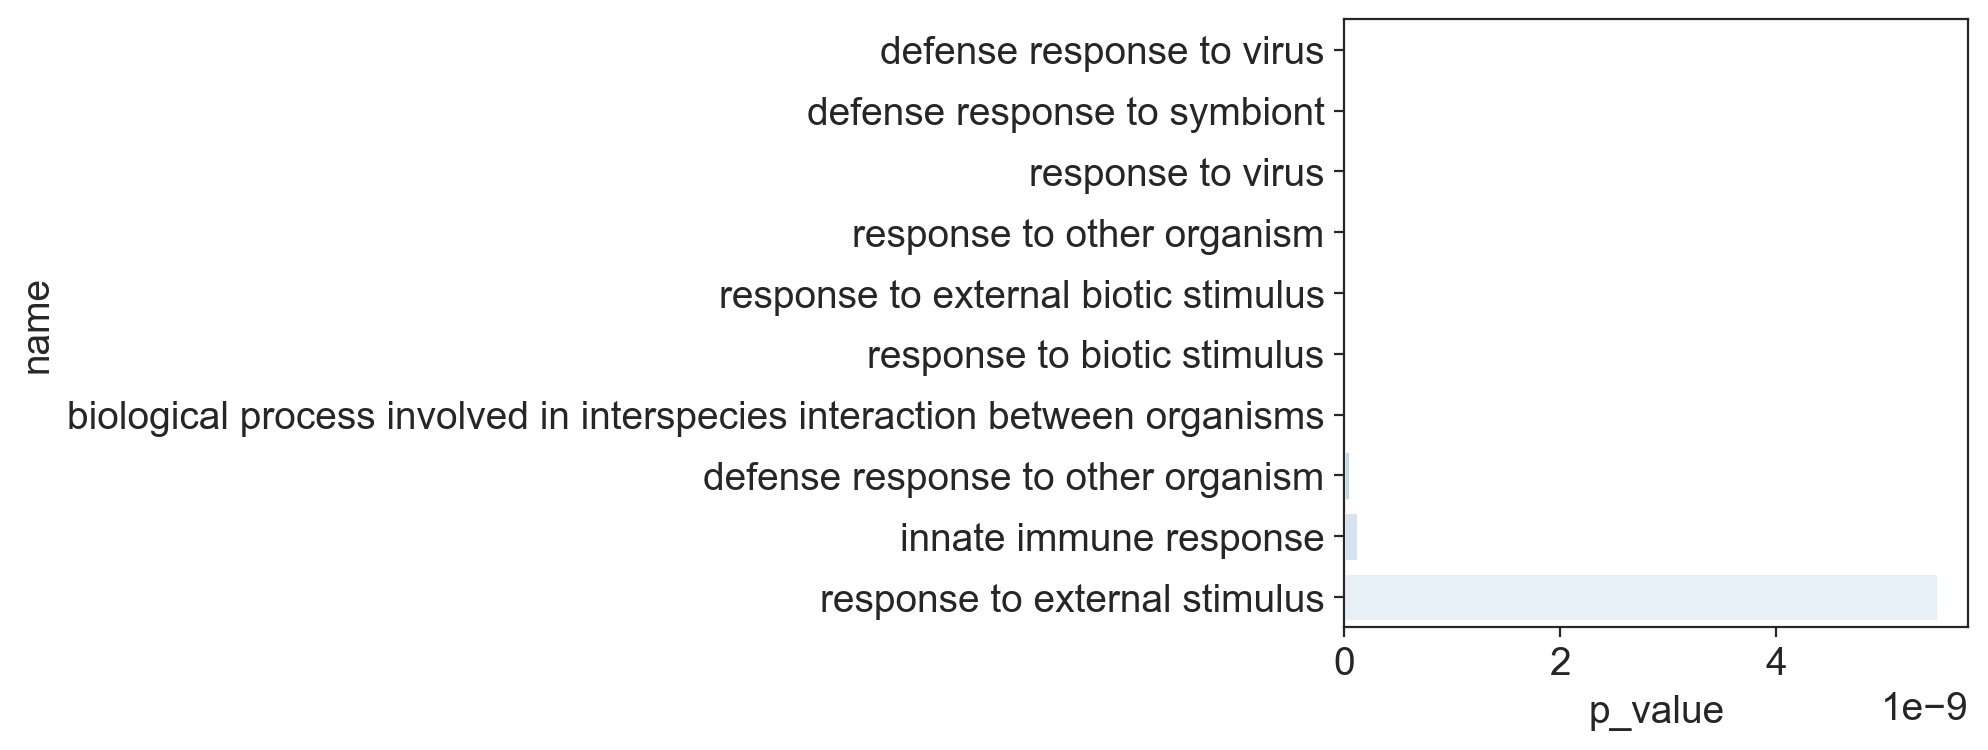

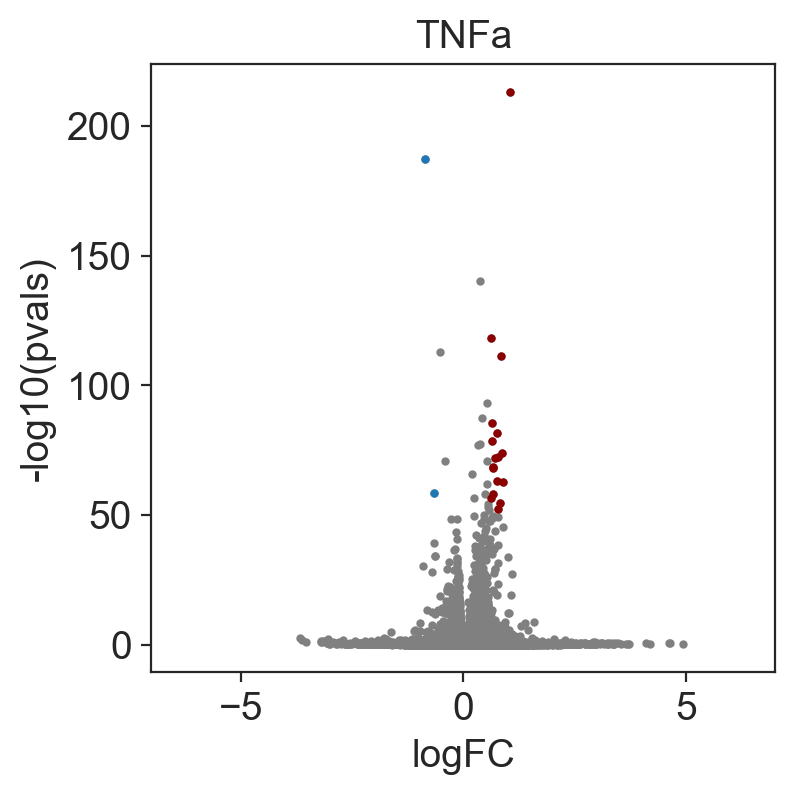

['TNFAIP2' 'SLC34A2' 'MSMB' 'BST2' 'IFIT3' 'MX1' 'IFIT2' 'IFIT1' 'OAS1'
 'ISG15' 'IFI44L' 'MX2' 'CXCL10' 'PI3' 'LYPD2' 'OASL' 'RSAD2']


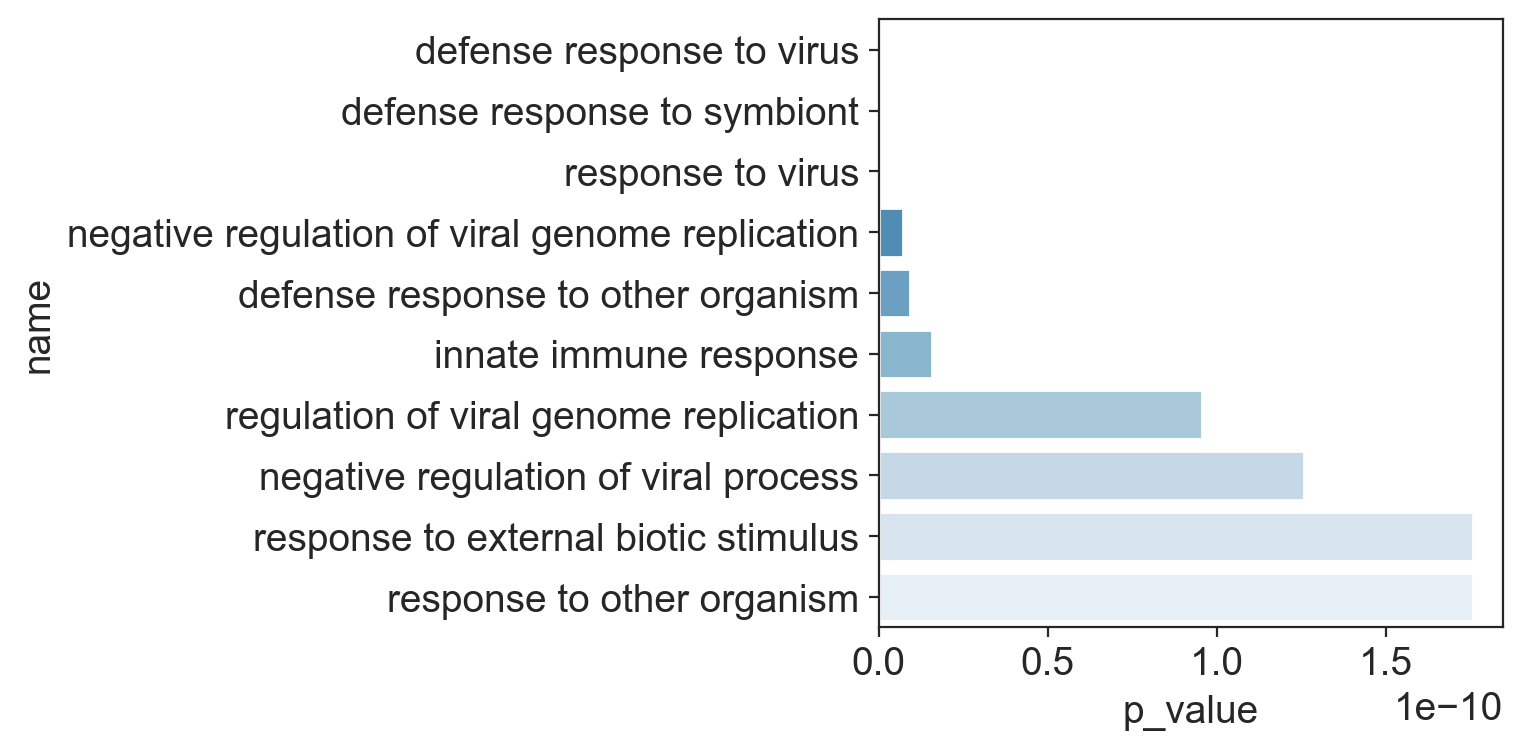

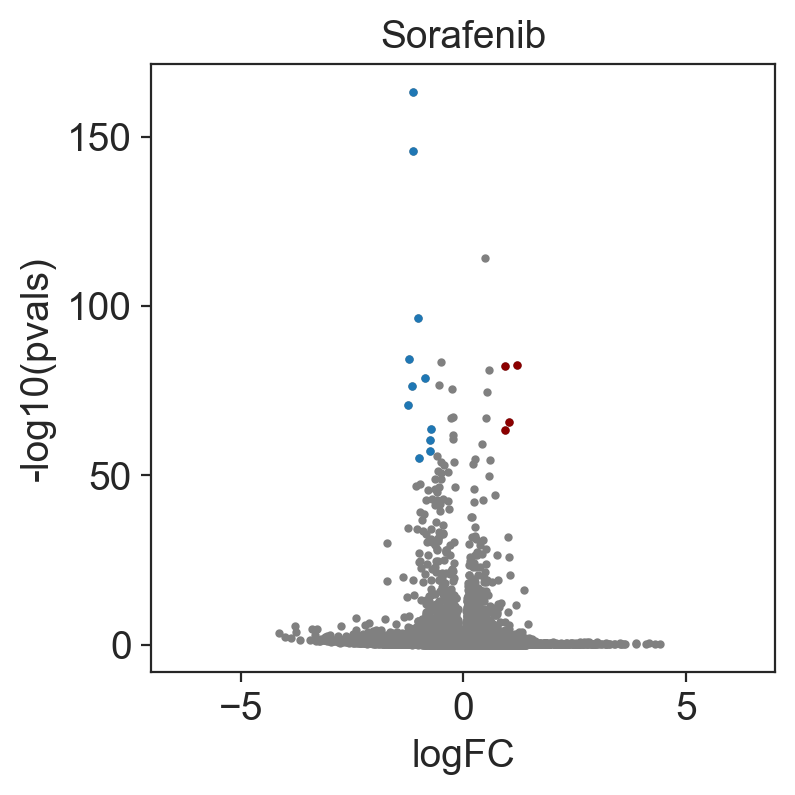

['DUSP6' 'VPS13D' 'CYP1B1' 'EGR1']


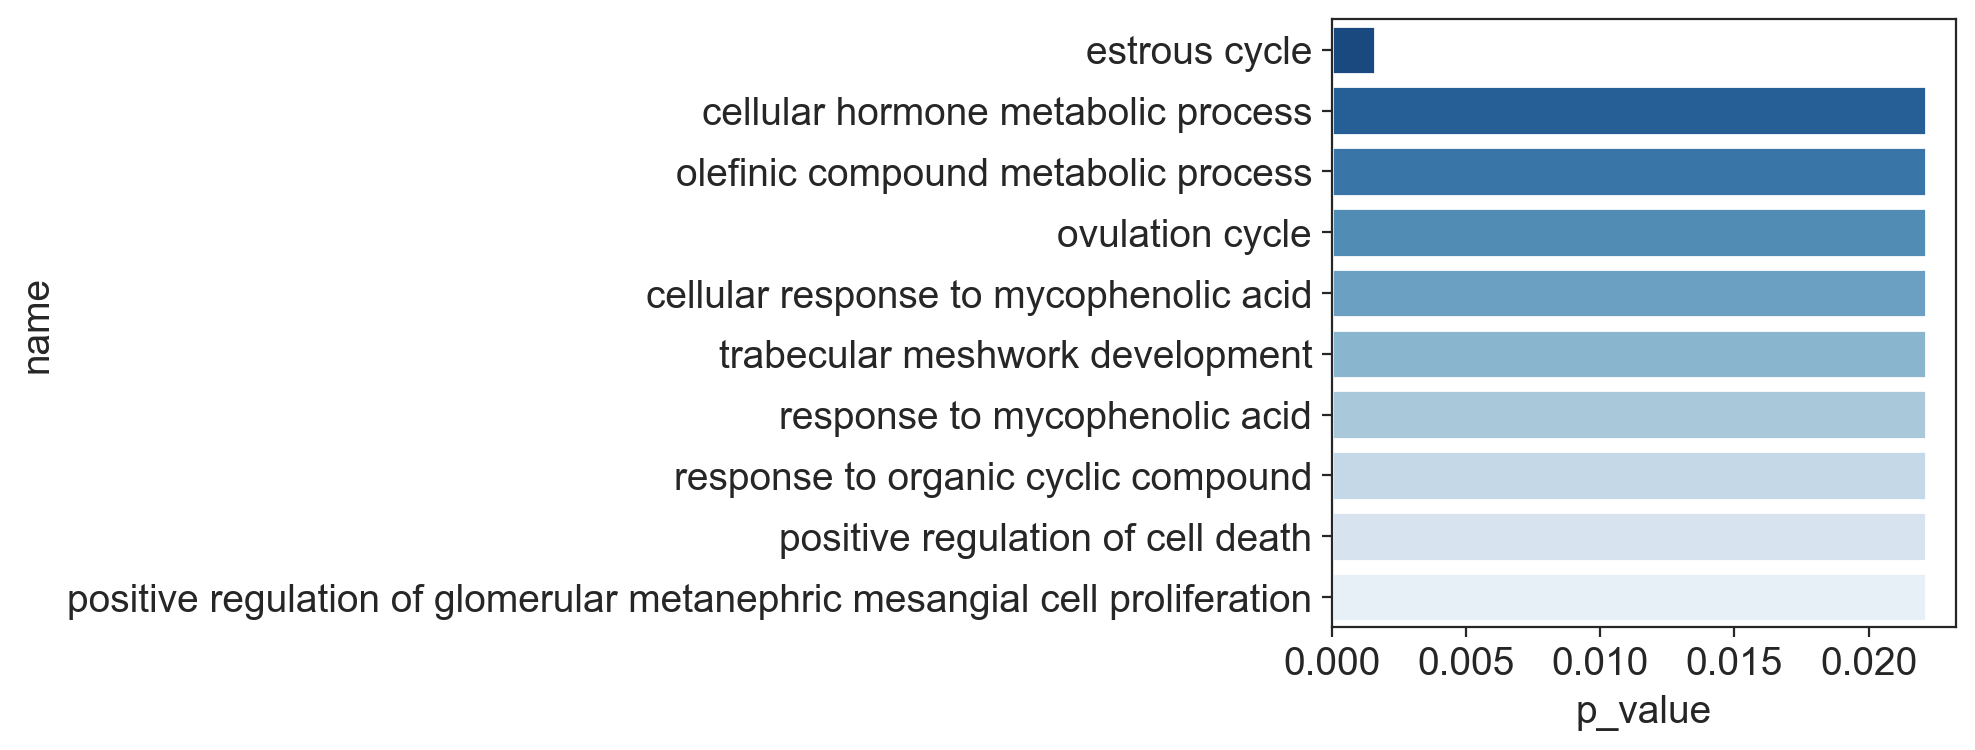

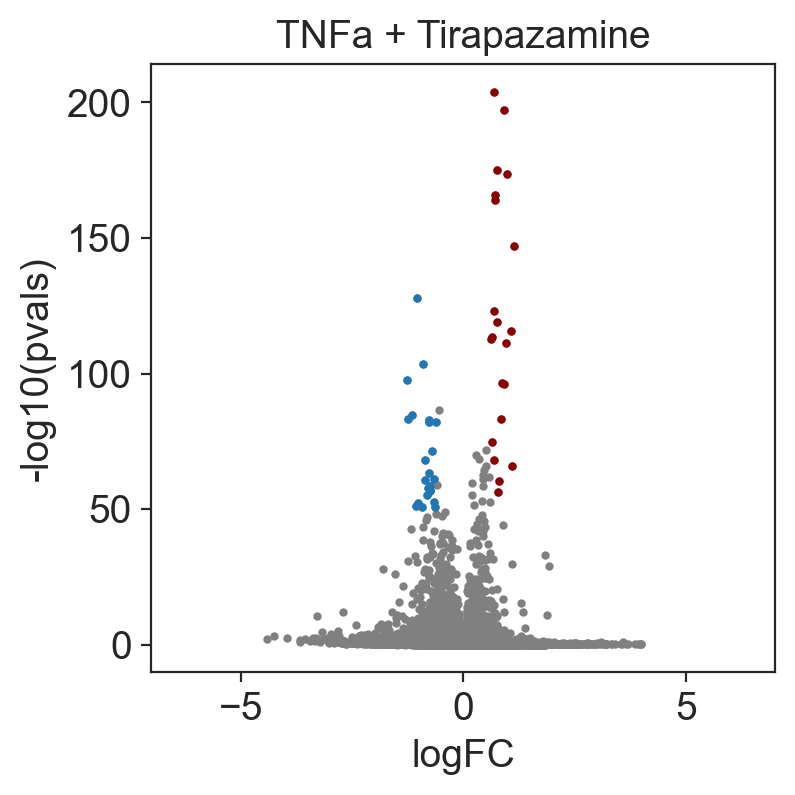

['CD74' 'SLC34A2' 'HLA-DRB1' 'CAPN13' 'HLA-DRA' 'CXCL8' 'MSMB' 'CP' 'VMO1'
 'BPIFA1' 'TMEM45A' 'RARRES1' 'BPIFB1' 'TNFAIP2' 'LYPD2' 'MUC5B' 'SGPP2'
 'HLA-DQB1' 'FMO2' 'WNT4' 'HLA-DQA1']


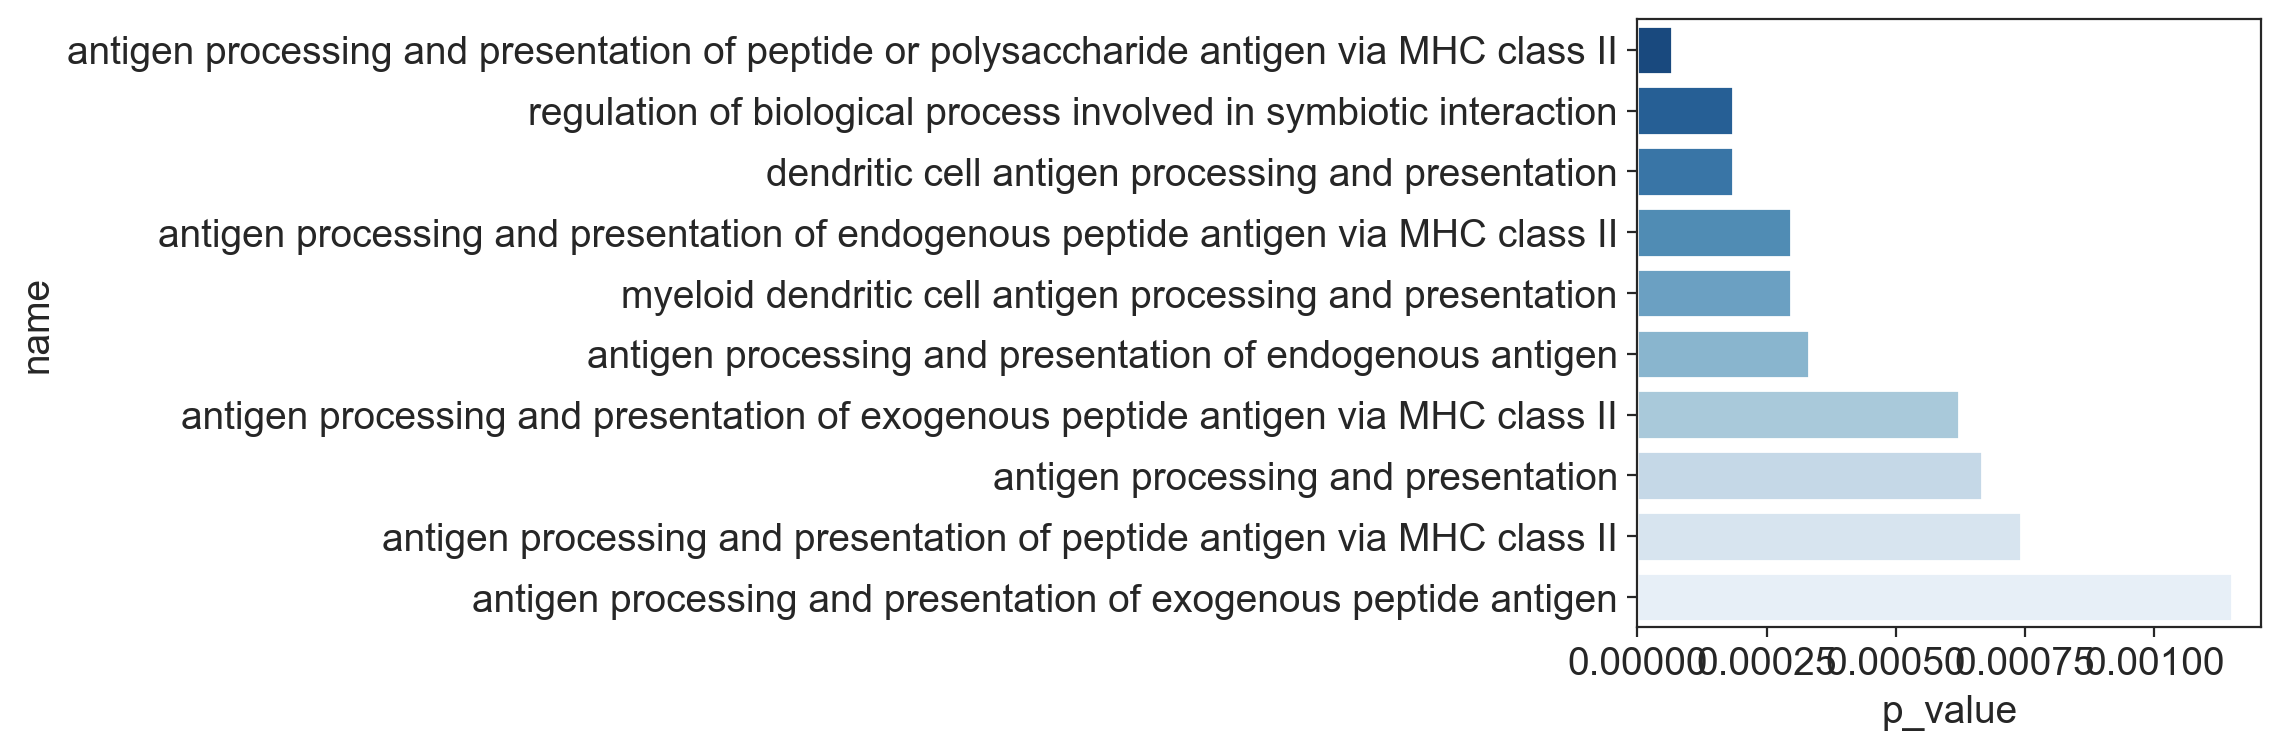

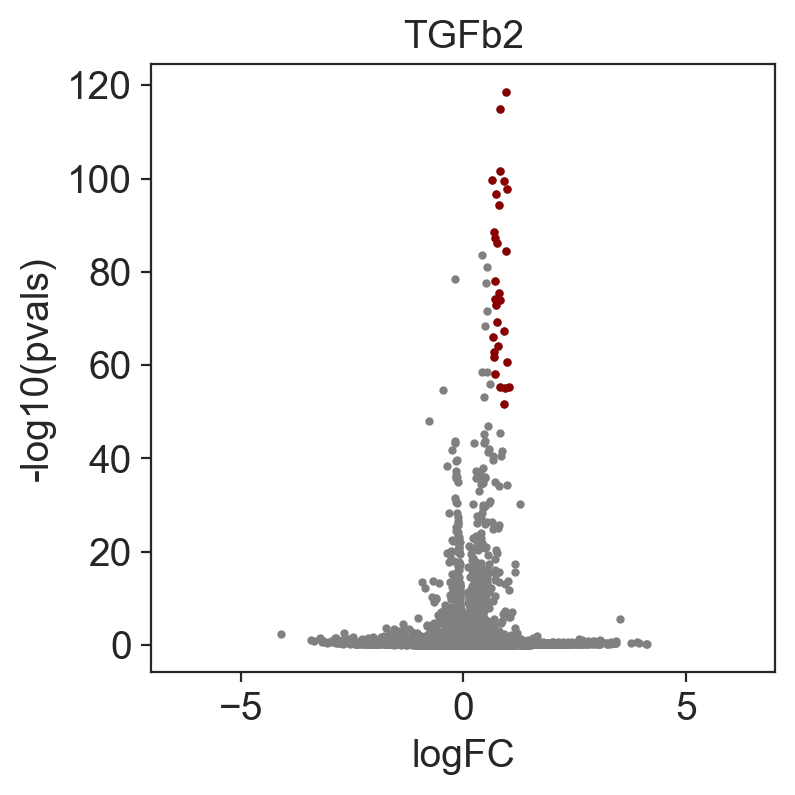

['IFIT1' 'SAMD9' 'ISG15' 'ISG20' 'MX2' 'IFIT2' 'MX1' 'IFIT3' 'BST2' 'IFI6'
 'OAS1' 'RSAD2' 'IFI35' 'OAS3' 'NT5C3A' 'IFITM1' 'EPSTI1' 'OAS2' 'OASL'
 'XAF1' 'DDX58' 'IRF7' 'SAMD9L' 'HERC5' 'IFIH1' 'CEACAM5' 'CMPK2' 'DDX60L'
 'TNFSF13B']


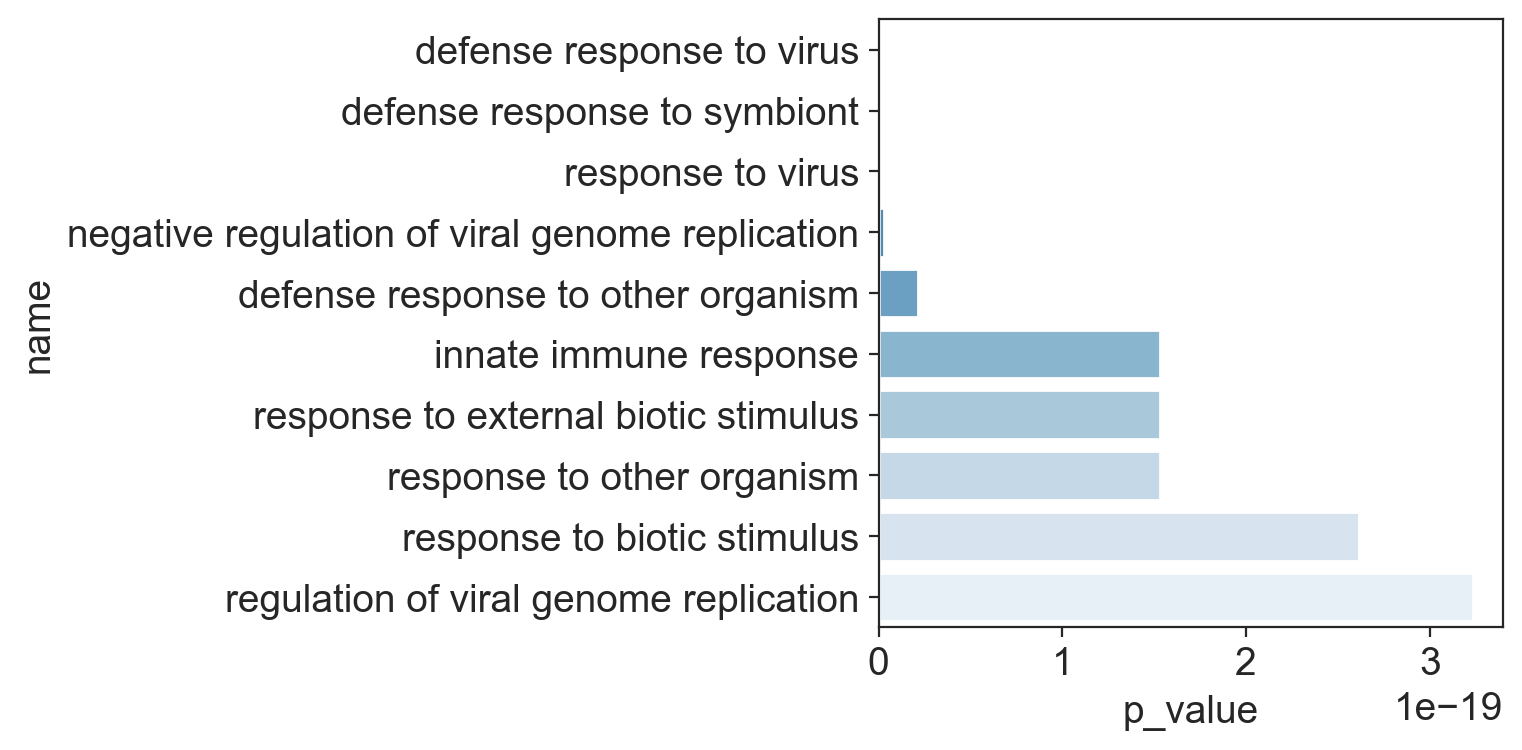

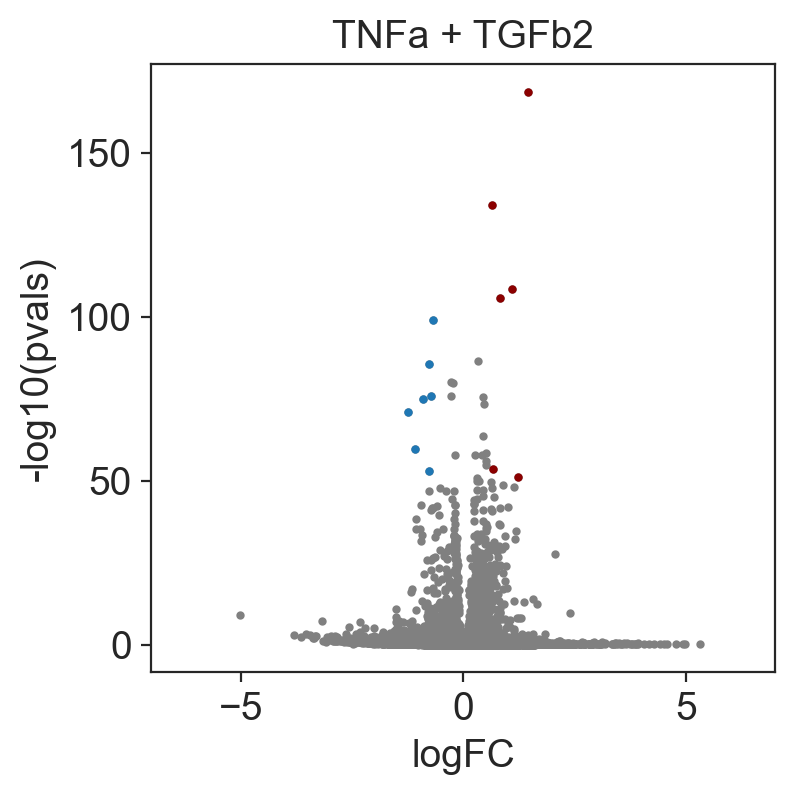

['MMP7' 'KRT17' 'IL32' 'SLC34A2' 'C15orf48' 'CXCL10']


ValueError: min() arg is an empty sequence

In [358]:
for trt in subset.obs.treatment.unique():
    if trt == 'mock' or trt in adata.uns['trt_categories']['IFNg'] or trt in adata.uns['trt_categories']['IFNa']:
        continue
    df, up, dn = plot_volcano(sc.get.rank_genes_groups_df(subset, group=trt), fc_thresh=.6, logpval_thresh=50)
    plt.title(trt)
    plt.show()

    diff_genes = list(up) + list(dn)
    if len(diff_genes) > 10:
#         sc.pl.dotplot(subset, groupby='cell_type', var_names=diff_genes, standard_scale='var', swap_axes=True)
        print(up)
        try:
            sns.barplot(data=enrich(up, subset.var_names).head(10), x='p_value', y='name', palette='Blues_r')
            plt.show()
        except ValueError:  # no pathways
            pass